# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import joblib
import logging
from itertools import product
import networkx as nx

logging.basicConfig(level=logging.INFO)

# Load dataset

In [2]:
df = pd.read_csv('data/Cleaned_Student_performance_data.csv')
logging.info(f"Dataset shape: {df.shape}")

INFO:root:Dataset shape: (2392, 15)


# Analyze dataset

INFO:root:Descriptive statistics:
INFO:root:         StudentID          Age       Gender    Ethnicity  ParentalEducation  \
count  2392.000000  2392.000000  2392.000000  2392.000000        2392.000000   
mean   2196.500000    16.468645     0.510870     0.877508           1.746237   
std     690.655244     1.123798     0.499986     1.028476           1.000411   
min    1001.000000    15.000000     0.000000     0.000000           0.000000   
25%    1598.750000    15.000000     0.000000     0.000000           1.000000   
50%    2196.500000    16.000000     1.000000     0.000000           2.000000   
75%    2794.250000    17.000000     1.000000     2.000000           2.000000   
max    3392.000000    18.000000     1.000000     3.000000           4.000000   

       StudyTimeWeekly     Absences     Tutoring  ParentalSupport  \
count      2392.000000  2392.000000  2392.000000      2392.000000   
mean          9.772199    14.541388     0.301421         2.122074   
std           5.652105     8

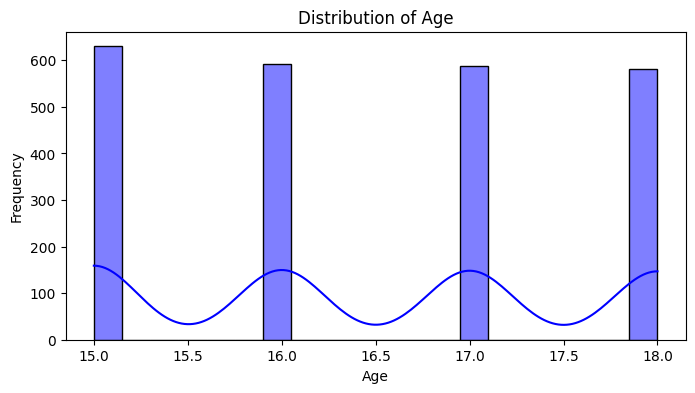

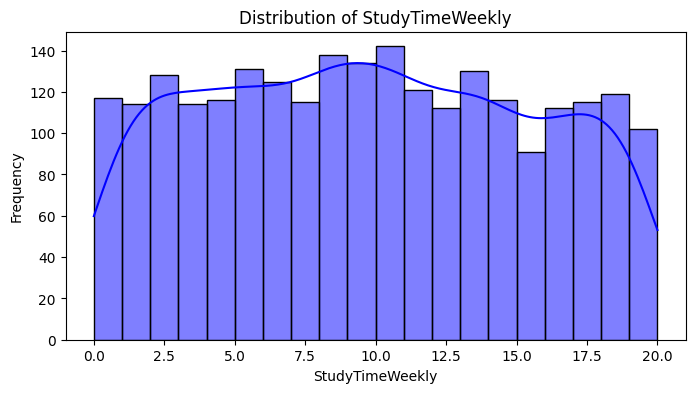

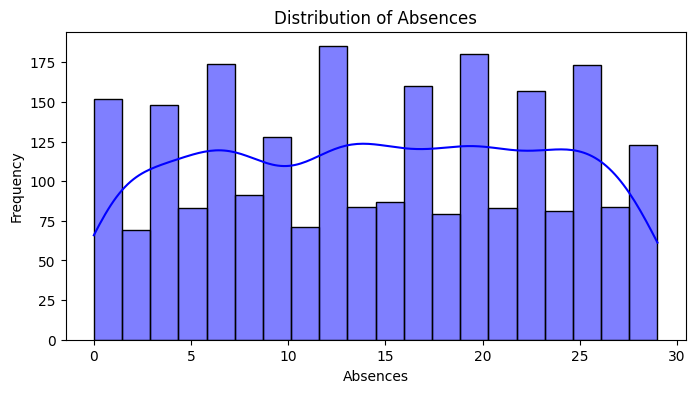

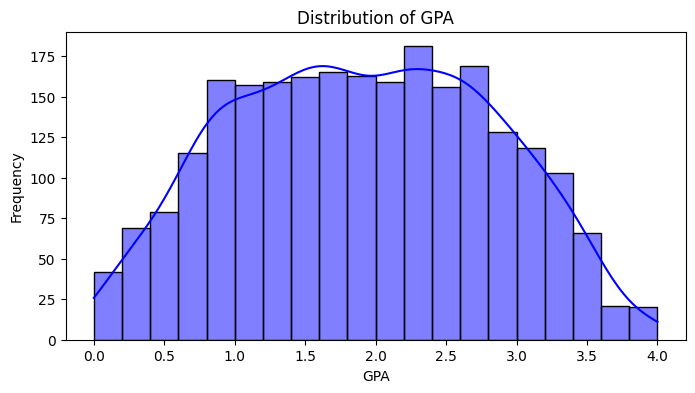

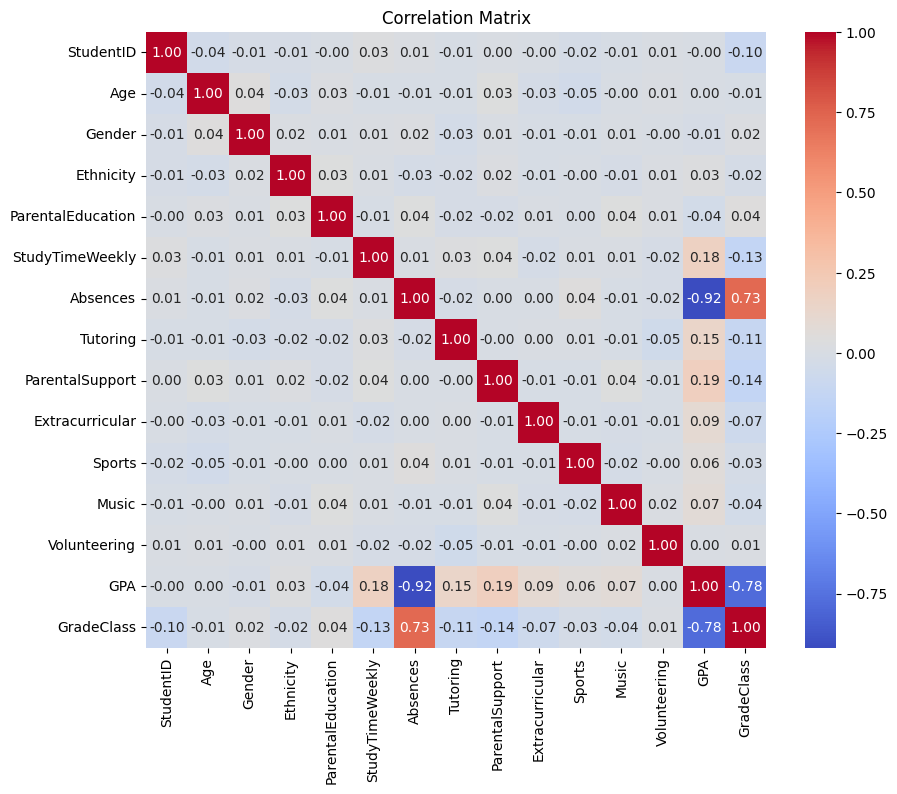

In [3]:
# Descriptive statistics
logging.info("Descriptive statistics:")
logging.info(df.describe())

# Check for missing values
missing_values = df.isnull().sum()
logging.info(f"Missing values:\n{missing_values}")

# Handle missing values (if any)
df.fillna(df.median(), inplace=True)  # Replace missing values with median

# Visualize distributions of numerical features
numerical_cols = ['Age', 'StudyTimeWeekly', 'Absences', 'GPA']
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=20, color='blue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Analyze correlations
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Discretize continuous features

In [4]:
gpa_bins   = [0, 1.0, 2.0, 3.0, 4.0]
gpa_labels = ['VeryLow', 'Low', 'Medium', 'High']
df['GPA_bin'] = pd.cut(df['GPA'], bins=gpa_bins, labels=gpa_labels, include_lowest=True)

study_bins   = [0, 5, 10, 15, 20, np.inf]
study_labels = ['VeryLow', 'Low', 'Medium', 'High', 'VeryHigh']
df['Study_bin'] = pd.cut(df['StudyTimeWeekly'], bins=study_bins, labels=study_labels, include_lowest=True)

abs_bins   = [0, 5, 10, 15, 20, np.inf]
abs_labels = ['None', 'Few', 'Moderate', 'High', 'VeryHigh']
df['Absences_bin'] = pd.cut(df['Absences'], bins=abs_bins, labels=abs_labels, include_lowest=True)

# Encode categorical variables

In [5]:
categorical_cols = [
    'Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 'ParentalSupport', 
    'Extracurricular', 'Sports', 'Music', 'Volunteering', 'Study_bin', 'Absences_bin', 'GPA_bin', 'GradeClass'
]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Feature selection and data split

In [6]:
features = [
    'ParentalEducation', 'Sports', 'Music', 'Volunteering', 'Extracurricular',  
    'Tutoring', 'Absences', 'StudyTimeWeekly', 'ParentalSupport'
]
target_gpa   = 'GPA'
target_class = 'GradeClass'

train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df[target_class]
)

# Define Bayesian Network structure

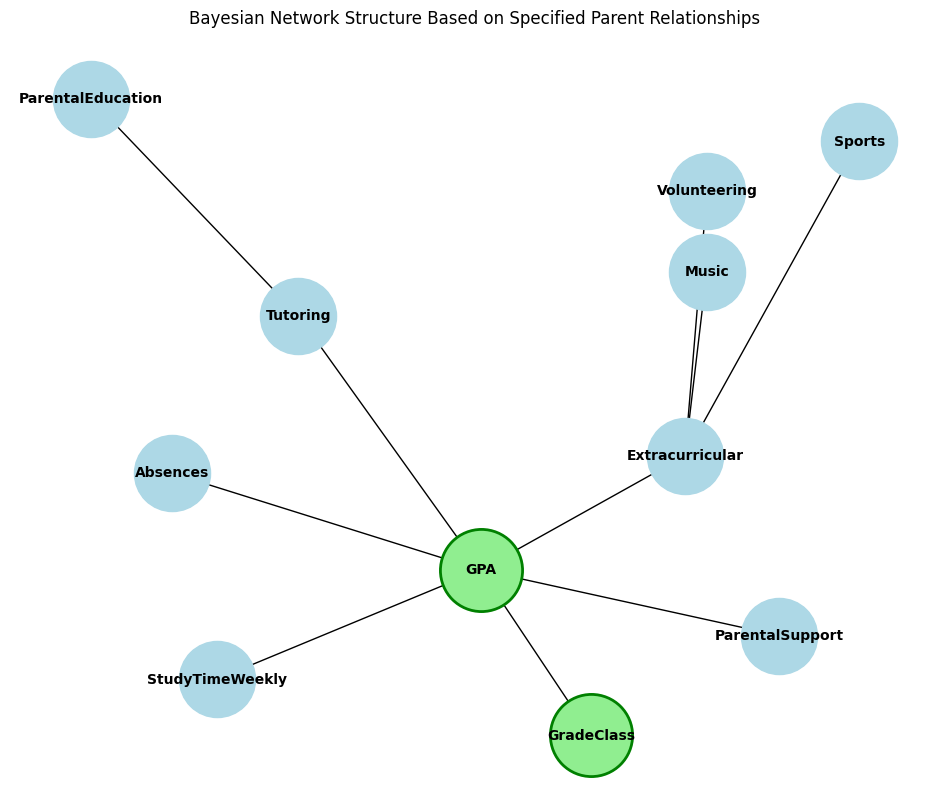

In [7]:
parents = {
    'ParentalEducation': [],
    'Sports': [],
    'Music': [],
    'Volunteering': [],
    'Extracurricular': ['Sports', 'Music', 'Volunteering'],
    'Tutoring': ['ParentalEducation'],
    'Absences': [],
    'StudyTimeWeekly': [],
    'ParentalSupport': [],
    'GPA': ['ParentalSupport', 'Absences', 'StudyTimeWeekly', 'Tutoring', 'Extracurricular'],
    'GradeClass': ['GPA']
}

# Visualize Bayesian Network structure
def visualize_bayesian_network(parents):
    G = nx.DiGraph()
    for child, pars in parents.items():
        for parent in pars:
            G.add_edge(parent, child)
    
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42)  # For consistent layout
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="lightblue")
    
    # Highlight target nodes
    target_nodes = ['GPA', 'GradeClass']
    nx.draw_networkx_nodes(G, pos, nodelist=target_nodes, node_size=3500, 
                           node_color="lightgreen", edgecolors='green', linewidths=2)
    
    # Draw edges and labels
    nx.draw_networkx_edges(G, pos, arrowsize=20)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")
    
    plt.title("Bayesian Network Structure Based on Specified Parent Relationships")
    plt.axis('off')
    plt.show()

visualize_bayesian_network(parents)

# Compute Conditional Probability Tables (CPTs)

In [8]:
CPT = {}

# Improved hyperparameters
laplace_smoothing = 2  # Increased smoothing for better generalization
min_data_threshold = 5  # Lower threshold to include more combinations

# Create simplified version of parents for the CPT
for node, pars in parents.items():
    if not pars:
        # For nodes without parents, calculate prior probabilities
        CPT[node] = train_df[node].value_counts(normalize=True).to_dict()
    else:
        # For nodes with parents, calculate conditional probabilities
        parent_values = [train_df[p].unique() for p in pars]
        combinations = list(product(*parent_values))
        table = {}
        classes = train_df[node].unique()
        
        # Track how many combinations are skipped
        skipped_combos = 0
        total_combos = len(combinations)
        
        # For nodes with many parents, limit the number of parents if combinations are too many
        if len(combinations) > 1000:
            logging.info(f"Too many combinations for {node}: {len(combinations)}. Using simplified model.")
            
            # For GPA, use a reduced feature set to improve coverage
            if node == 'GPA':
                important_features = ['StudyTimeWeekly', 'Absences', 'ParentalSupport']
                reduced_pars = important_features
                
                # Recalculate combinations
                parent_values = [train_df[p].unique() for p in reduced_pars]
                combinations = list(product(*parent_values))
                pars = reduced_pars
                logging.info(f"Reduced parents for {node} to: {pars}")
                total_combos = len(combinations)
        
        for combo in combinations:
            # Create a mask for the current combination of parent values
            mask = np.ones(len(train_df), dtype=bool)
            for p, v in zip(pars, combo):
                mask &= (train_df[p] == v)
            subset = train_df[mask]

            # Check if the subset has enough data points
            if len(subset) < min_data_threshold:
                skipped_combos += 1
                # For low data, still calculate but with higher smoothing
                if len(subset) > 0:
                    counts = subset[node].value_counts()
                    total = counts.sum()
                    local_smoothing = laplace_smoothing + (min_data_threshold - len(subset))
                    probs = {
                        c: (counts.get(c, 0) + local_smoothing) / (total + local_smoothing * len(classes))
                        for c in classes
                    }
                    table[combo] = probs
                continue

            # Calculate counts and probabilities with Laplace smoothing
            counts = subset[node].value_counts()
            total = counts.sum()
            probs = {
                c: (counts.get(c, 0) + laplace_smoothing) / (total + laplace_smoothing * len(classes))
                for c in classes
            }
            table[combo] = probs
        
        logging.info(f"For {node}: Used {len(table)}/{total_combos} combinations ({skipped_combos} skipped)")
        CPT[node] = table

# Log the size of each CPT
for node, table in CPT.items():
    if isinstance(table, dict) and not all(isinstance(k, int) or isinstance(k, float) for k in table.keys()):
        logging.info(f"CPT for node {node} contains {len(table)} entries.")
    else:
        logging.info(f"CPT for node {node} contains prior probabilities.")

# Create simplified predictors for fallback
simplified_predictors = {}
for target in ['GPA', 'GradeClass']:
    # Create simple one-feature predictors for each parent
    parent_features = parents.get(target, [])
    for feature in parent_features:
        table = {}
        for value in train_df[feature].unique():
            subset = train_df[train_df[feature] == value]
            if len(subset) > 0:
                probs = {}
                for c in train_df[target].unique():
                    count = len(subset[subset[target] == c])
                    probs[c] = (count + laplace_smoothing) / (len(subset) + laplace_smoothing * len(train_df[target].unique()))
                table[value] = probs
        simplified_predictors[(target, feature)] = table

# Train regression models for continuous GPA prediction
X_gpa_train = train_df[parents['GPA']]
y_gpa_train = train_df['GPA']

lr_model = LinearRegression()
lr_model.fit(X_gpa_train, y_gpa_train)

rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_gpa_train, y_gpa_train)

# Create GPA range mapping for each discrete GPA value
gpa_value_ranges = {}
for gpa_value in train_df['GPA'].unique():
    similar_values = train_df[abs(train_df['GPA'] - gpa_value) < 0.1]['GPA']
    if len(similar_values) > 0:
        gpa_value_ranges[gpa_value] = (similar_values.mean(), similar_values.std())
    else:
        gpa_value_ranges[gpa_value] = (gpa_value, 0.1)  # Default fallback

INFO:root:For Extracurricular: Used 8/8 combinations (0 skipped)
INFO:root:For Tutoring: Used 5/5 combinations (0 skipped)
INFO:root:Too many combinations for GPA: 120600. Using simplified model.
INFO:root:Reduced parents for GPA to: ['StudyTimeWeekly', 'Absences', 'ParentalSupport']
INFO:root:For GPA: Used 1840/30150 combinations (30150 skipped)
INFO:root:For GradeClass: Used 376/376 combinations (173 skipped)
INFO:root:CPT for node ParentalEducation contains prior probabilities.
INFO:root:CPT for node Sports contains prior probabilities.
INFO:root:CPT for node Music contains prior probabilities.
INFO:root:CPT for node Volunteering contains prior probabilities.
INFO:root:CPT for node Extracurricular contains 8 entries.
INFO:root:CPT for node Tutoring contains 5 entries.
INFO:root:CPT for node Absences contains prior probabilities.
INFO:root:CPT for node StudyTimeWeekly contains prior probabilities.
INFO:root:CPT for node ParentalSupport contains prior probabilities.
INFO:root:CPT for 

# Save model to .pkl

In [9]:
model_data = {
    'CPT': CPT,
    'parents': parents,
    'label_encoders': label_encoders,
    'features': features,
    'target_gpa': target_gpa,
    'target_class': target_class,
    'simplified_predictors': simplified_predictors,
    'lr_model': lr_model,
    'rf_model': rf_model,
    'gpa_value_ranges': gpa_value_ranges
}
joblib.dump(model_data, 'models/bayesian_model.pkl')

# Create a simple quantile mapping for prediction
gpa_quantiles = {}
for i in range(5):  # 0, 1, 2, 3, 4 = Very Low, Low, Medium, High
    gpa_quantiles[i] = train_df['GPA'].quantile(i/4)
joblib.dump(gpa_quantiles, 'models/gpa_quantiles.pkl')

logging.info("Model and GPA quantiles saved successfully.")

INFO:root:Model and GPA quantiles saved successfully.


# Define prediction functions

In [10]:
def predict_gpa_improved(row):
    # Get the parent values for GPA
    parent_values = []
    for p in parents['GPA']:
        if p in row:
            parent_values.append(row[p])
        else:
            # If parent not in row, use most common value
            parent_values.append(train_df[p].mode()[0])
    
    key = tuple(parent_values)
    
    # Get Bayesian Network discrete prediction
    bayesian_prediction = None
    bayesian_confidence = 0.5  # Default confidence
    
    if 'GPA' in CPT and key in CPT['GPA']:
        probs = CPT['GPA'][key]
        bayesian_prediction = max(probs, key=probs.get)
        bayesian_confidence = probs[bayesian_prediction]
    else:
        # Fallback: Try simpler models based on individual features
        for i, p in enumerate(parents['GPA']):
            if (target_gpa, p) in simplified_predictors:
                p_value = parent_values[i]
                if p_value in simplified_predictors[(target_gpa, p)]:
                    simple_probs = simplified_predictors[(target_gpa, p)][p_value]
                    if simple_probs:
                        bayesian_prediction = max(simple_probs, key=simple_probs.get)
                        bayesian_confidence = simple_probs[bayesian_prediction]
                        break
        
        # If still no prediction, use prior distribution
        if bayesian_prediction is None:
            prior = train_df['GPA'].value_counts(normalize=True).to_dict()
            bayesian_prediction = max(prior, key=prior.get)
            bayesian_confidence = 0.3  # Lower confidence for prior-based prediction
    
    # Get continuous predictions from regression models
    X_features = np.array([row[p] for p in parents['GPA']]).reshape(1, -1)
    lr_prediction = lr_model.predict(X_features)[0]
    rf_prediction = rf_model.predict(X_features)[0]
    
    # Convert discrete Bayesian prediction to continuous range
    if bayesian_prediction in gpa_value_ranges:
        mean_value, _ = gpa_value_ranges[bayesian_prediction]
    else:
        # If no range mapping found, use the discrete prediction directly
        mean_value = bayesian_prediction
    
    # Create an ensemble prediction
    # More weight to Bayesian when confidence is high, more to regression models when low
    if bayesian_confidence > 0.7:
        # High confidence - trust Bayesian more
        weights = [0.6, 0.2, 0.2]  # Bayesian, LR, RF
    elif bayesian_confidence > 0.4:
        # Medium confidence
        weights = [0.4, 0.3, 0.3]
    else:
        # Low confidence - trust regression models more
        weights = [0.2, 0.4, 0.4]
    
    final_prediction = (
        weights[0] * mean_value +
        weights[1] * lr_prediction +
        weights[2] * rf_prediction
    )
    
    # Constrain to valid GPA range
    final_prediction = max(0.0, min(4.0, final_prediction))
    return final_prediction

def predict_gradeclass(row):
    # For GradeClass, parent is GPA
    if 'GPA' not in row:
        # If GPA is not available, predict it first
        gpa_value = predict_gpa_improved(row)
    else:
        gpa_value = row['GPA']
    
    # Map to a valid key in the CPT
    # Find the closest GPA value in the training set
    gpa_values_in_train = sorted(train_df['GPA'].unique())
    closest_gpa = min(gpa_values_in_train, key=lambda x: abs(x - gpa_value))
    
    key = (closest_gpa,)
    
    if 'GradeClass' in CPT and key in CPT['GradeClass']:
        probs = CPT['GradeClass'][key]
        return max(probs, key=probs.get)
    
    # Fallback: Map GPA to GradeClass using bins
    if gpa_value < 1.0:
        return 0  # Assuming 0 is the encoded value for lowest grade
    elif gpa_value < 2.0:
        return 1
    elif gpa_value < 3.0:
        return 2
    else:
        return 3  # Assuming 3 is the encoded value for highest grade

# Predict and evaluate

Starting cross-validation with filtered output...

INFO: Processing fold 1/5

Debugging GPA_bin accuracy calculation:
Sample of Actual GPA_bin_recreated: ['VeryLow', 'Medium', 'Low']
Sample of BN_Predicted_GPA_bin_recreated: ['VeryLow', 'Medium', 'Low']
Types - Actual: <class 'str'>, Predicted: <class 'str'>
GPA_bin accuracy with recreated bins: 0.7787

Distribusi nilai GPA_bin:
Aktual: {'Low': 167, 'Medium': 164, 'VeryLow': 83, 'High': 65}
Prediksi: {'Low': 210, 'Medium': 173, 'VeryLow': 64, 'High': 32}
INFO: Fold 1 - BN: MAE=0.2458, RMSE=0.3088, Acc=0.8998
INFO: Processing fold 2/5
INFO: Fold 2 - BN: MAE=0.2507, RMSE=0.3072, Acc=0.9144
INFO: Processing fold 3/5
INFO: Fold 3 - BN: MAE=0.2497, RMSE=0.3188, Acc=0.9414
INFO: Processing fold 4/5
INFO: Fold 4 - BN: MAE=0.2572, RMSE=0.3132, Acc=0.9414
INFO: Processing fold 5/5
INFO: Fold 5 - BN: MAE=0.2890, RMSE=0.3637, Acc=0.9017

=== Cross-Validation Results (k=5) ===
╒════════════════════════╤════════════════════╤═════════════════╤══════

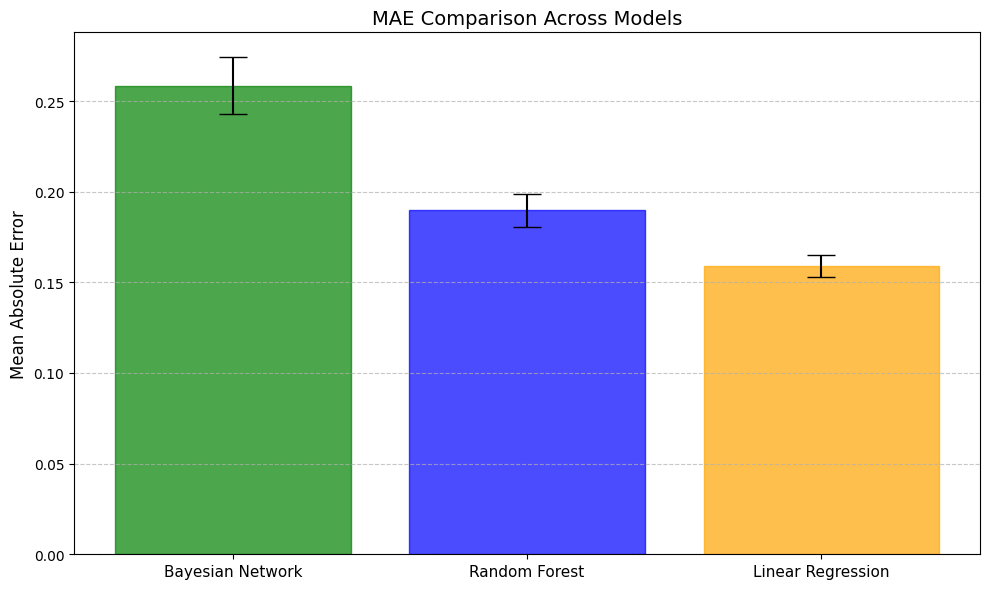

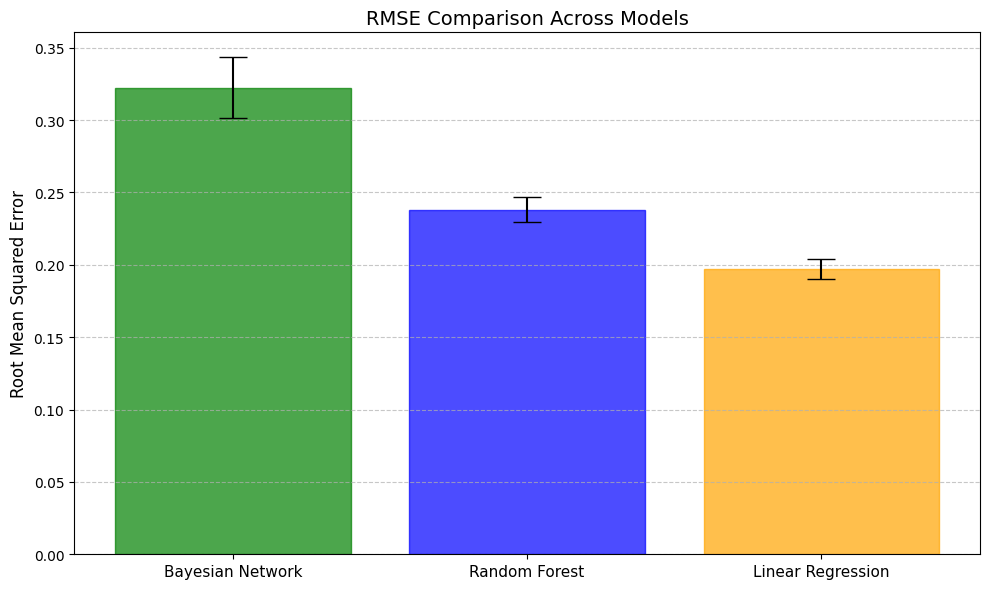

<Figure size 1200x800 with 0 Axes>

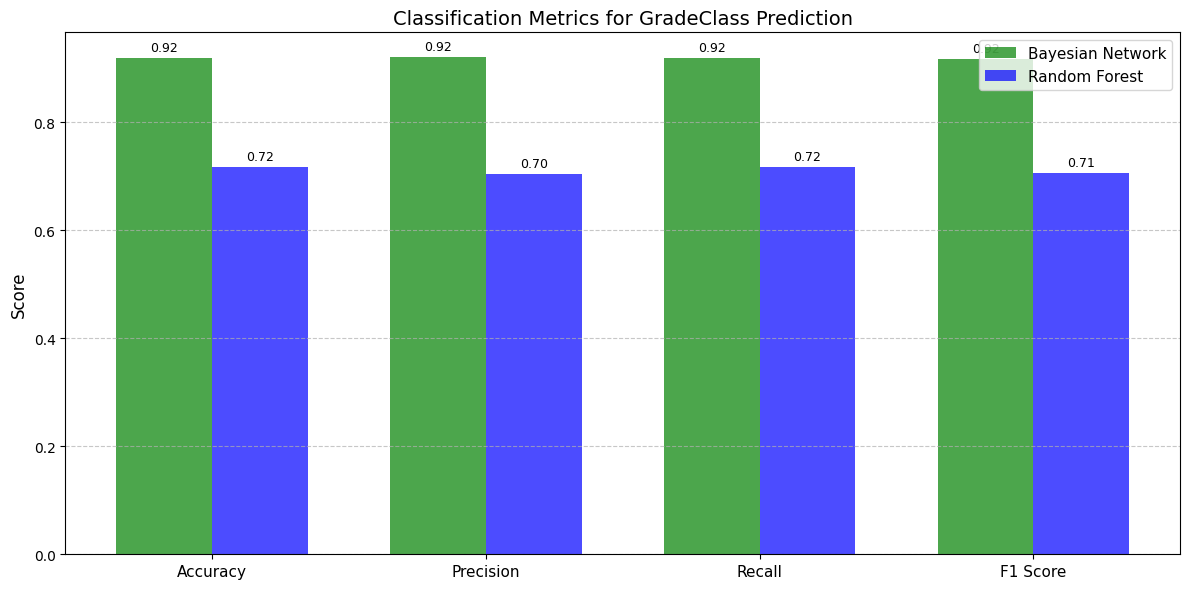

INFO: Cross-validation evaluation metrics saved successfully.

Applying best model to test set...

=== Final Model Performance on Test Set ===
MAE (GPA): 0.2668
RMSE (GPA): 0.3323
Accuracy (GradeClass): 0.9165
Precision (GradeClass): 0.9179
Recall (GradeClass): 0.9165
F1 Score (GradeClass): 0.9137

=== Comparison with Naive Baseline ===
Naive Baseline - MAE (GPA): 0.7450, RMSE (GPA): 0.8828
Improvement over baseline - MAE: 64.19%, RMSE: 62.37%


In [20]:
# Predict and evaluate with advanced metrics, k-fold cross-validation, and model comparison
# Suppress scikit-learn warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.utils.validation')
warnings.filterwarnings('ignore', message='X does not have valid feature names, but LinearRegression was fitted with feature names')
warnings.filterwarnings('ignore', message='X does not have valid feature names, but RandomForestRegressor was fitted with feature names')

from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, ParameterGrid
from tabulate import tabulate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Configure logging to show only important information
class CustomHandler(logging.StreamHandler):
    def emit(self, record):
        # Show only processing fold messages and final results
        if "Processing fold" in record.getMessage() or "Cross-validation" in record.getMessage():
            print(f"INFO: {record.getMessage()}")
        elif "Fold" in record.getMessage() and "BN:" in record.getMessage():
            print(f"INFO: {record.getMessage()}")

# Set up custom logger
logger = logging.getLogger()
for handler in logger.handlers[:]:
    logger.removeHandler(handler)
logger.addHandler(CustomHandler())
logger.setLevel(logging.INFO)
print("Starting cross-validation with filtered output...\n")

# 1. Define K-Fold Cross-Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize result containers
cv_results_bn = {
    'mae': [], 'rmse': [], 'gpa_bin_accuracy': [], 
    'class_accuracy': [], 'precision': [], 'recall': [], 'f1': []
}
cv_results_rf = {
    'mae': [], 'rmse': [], 'gpa_bin_accuracy': [], 
    'class_accuracy': [], 'precision': [], 'recall': [], 'f1': []
}
cv_results_lr = {
    'mae': [], 'rmse': []
}

# 2. Run cross-validation
fold_idx = 1
for train_idx, test_idx in kf.split(df):
    logging.info(f"Processing fold {fold_idx}/{k_folds}")
    
    # Split data
    cv_train_df = df.iloc[train_idx].copy()
    cv_test_df = df.iloc[test_idx].copy()
    
    # === BAYESIAN NETWORK MODEL ===
    # Re-train CPTs on this fold's training data
    fold_CPT = {}
    for node, pars in parents.items():
        if not pars:
            # For nodes without parents, calculate prior probabilities
            fold_CPT[node] = cv_train_df[node].value_counts(normalize=True).to_dict()
        else:
            # For nodes with parents, calculate conditional probabilities
            parent_values = [cv_train_df[p].unique() for p in pars]
            combinations = list(product(*parent_values))
            table = {}
            classes = cv_train_df[node].unique()
            
            # Simplify if too many combinations
            if len(combinations) > 1000 and node == 'GPA':
                important_features = ['StudyTimeWeekly', 'Absences', 'ParentalSupport']
                pars = important_features
                parent_values = [cv_train_df[p].unique() for p in pars]
                combinations = list(product(*parent_values))
            
            for combo in combinations:
                # Create mask for parent value combination
                mask = np.ones(len(cv_train_df), dtype=bool)
                for p, v in zip(pars, combo):
                    mask &= (cv_train_df[p] == v)
                subset = cv_train_df[mask]

                # Calculate probabilities with Laplace smoothing
                if len(subset) >= min_data_threshold:
                    counts = subset[node].value_counts()
                    total = counts.sum()
                    probs = {
                        c: (counts.get(c, 0) + laplace_smoothing) / 
                           (total + laplace_smoothing * len(classes))
                        for c in classes
                    }
                    table[combo] = probs
                elif len(subset) > 0:
                    # Higher smoothing for small subsets
                    counts = subset[node].value_counts()
                    total = counts.sum()
                    local_smoothing = laplace_smoothing + (min_data_threshold - len(subset))
                    probs = {
                        c: (counts.get(c, 0) + local_smoothing) / 
                           (total + local_smoothing * len(classes))
                        for c in classes
                    }
                    table[combo] = probs
            
            fold_CPT[node] = table
    
    # Train regression models for this fold
    X_train = cv_train_df[parents['GPA']]
    y_train = cv_train_df['GPA']
    
    fold_lr_model = LinearRegression()
    fold_lr_model.fit(X_train, y_train)
    
    fold_rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    fold_rf_model.fit(X_train, y_train)
    
    # Create simplified predictors for the fold
    fold_simplified_predictors = {}
    for target in ['GPA', 'GradeClass']:
        parent_features = parents.get(target, [])
        for feature in parent_features:
            table = {}
            for value in cv_train_df[feature].unique():
                subset = cv_train_df[cv_train_df[feature] == value]
                if len(subset) > 0:
                    probs = {}
                    for c in cv_train_df[target].unique():
                        count = len(subset[subset[target] == c])
                        probs[c] = (count + laplace_smoothing) / (len(subset) + laplace_smoothing * len(cv_train_df[target].unique()))
                    table[value] = probs
            fold_simplified_predictors[(target, feature)] = table

    # Create GPA value ranges for this fold
    fold_gpa_value_ranges = {}
    for gpa_value in cv_train_df['GPA'].unique():
        similar_values = cv_train_df[abs(cv_train_df['GPA'] - gpa_value) < 0.1]['GPA']
        if len(similar_values) > 0:
            fold_gpa_value_ranges[gpa_value] = (similar_values.mean(), similar_values.std())
        else:
            fold_gpa_value_ranges[gpa_value] = (gpa_value, 0.1)
    
    # Define prediction functions for this fold
    def fold_predict_gpa_improved(row, fold_CPT=fold_CPT, fold_lr_model=fold_lr_model, 
                                 fold_rf_model=fold_rf_model, fold_simplified_predictors=fold_simplified_predictors,
                                 fold_gpa_value_ranges=fold_gpa_value_ranges):
        # Get parent values
        parent_values = []
        for p in parents['GPA']:
            if p in row:
                parent_values.append(row[p])
            else:
                parent_values.append(cv_train_df[p].mode()[0])
        
        key = tuple(parent_values)
        
        # Bayesian prediction
        bayesian_prediction = None
        bayesian_confidence = 0.5
        
        if 'GPA' in fold_CPT and key in fold_CPT['GPA']:
            probs = fold_CPT['GPA'][key]
            bayesian_prediction = max(probs, key=probs.get)
            bayesian_confidence = probs[bayesian_prediction]
        else:
            # Try simpler models
            for i, p in enumerate(parents['GPA']):
                if (target_gpa, p) in fold_simplified_predictors:
                    p_value = parent_values[i]
                    if p_value in fold_simplified_predictors[(target_gpa, p)]:
                        simple_probs = fold_simplified_predictors[(target_gpa, p)][p_value]
                        if simple_probs:
                            bayesian_prediction = max(simple_probs, key=simple_probs.get)
                            bayesian_confidence = simple_probs[bayesian_prediction]
                            break
            
            # Use prior as fallback
            if bayesian_prediction is None:
                prior = cv_train_df['GPA'].value_counts(normalize=True).to_dict()
                bayesian_prediction = max(prior, key=prior.get)
                bayesian_confidence = 0.3
        
        # Regression predictions
        X_features = np.array([row[p] for p in parents['GPA']]).reshape(1, -1)
        lr_prediction = fold_lr_model.predict(X_features)[0]
        rf_prediction = fold_rf_model.predict(X_features)[0]
        
        # Convert discrete prediction to continuous
        if bayesian_prediction in fold_gpa_value_ranges:
            mean_value, _ = fold_gpa_value_ranges[bayesian_prediction]
        else:
            mean_value = bayesian_prediction
        
        # Ensemble prediction with adaptive weighting
        if bayesian_confidence > 0.7:
            weights = [0.6, 0.2, 0.2]
        elif bayesian_confidence > 0.4:
            weights = [0.4, 0.3, 0.3]
        else:
            weights = [0.2, 0.4, 0.4]
        
        final_prediction = (
            weights[0] * mean_value +
            weights[1] * lr_prediction +
            weights[2] * rf_prediction
        )
        
        # Constrain to valid range
        return max(0.0, min(4.0, final_prediction))

    def fold_predict_gradeclass(row, fold_CPT=fold_CPT):
        # Get GPA value
        if 'GPA' not in row:
            gpa_value = fold_predict_gpa_improved(row)
        else:
            gpa_value = row['GPA']
        
        # Find closest GPA value in training set
        gpa_values_in_train = sorted(cv_train_df['GPA'].unique())
        closest_gpa = min(gpa_values_in_train, key=lambda x: abs(x - gpa_value))
        
        key = (closest_gpa,)
        
        if 'GradeClass' in fold_CPT and key in fold_CPT['GradeClass']:
            probs = fold_CPT['GradeClass'][key]
            return max(probs, key=probs.get)
        
        # Fallback mapping
        if gpa_value < 1.0:
            return 0
        elif gpa_value < 2.0:
            return 1
        elif gpa_value < 3.0:
            return 2
        else:
            return 3
    
    # === BASELINE MODELS FOR COMPARISON ===
    # Random Forest for GPA regression
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(cv_train_df[features], cv_train_df['GPA'])
    
    # Random Forest for GPA_bin classification
    rf_gpa_bin = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_gpa_bin.fit(cv_train_df[features], cv_train_df['GPA_bin'])
    
    # Random Forest for GradeClass classification
    rf_gradeclass = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_gradeclass.fit(cv_train_df[features], cv_train_df['GradeClass'])
    
    # Linear Regression for GPA
    lr_gpa = LinearRegression()
    lr_gpa.fit(cv_train_df[features], cv_train_df['GPA'])
    
    # === MAKE PREDICTIONS FOR THIS FOLD ===
    
    # Bayesian Network predictions
    cv_test_df['BN_Predicted_GPA'] = cv_test_df.apply(fold_predict_gpa_improved, axis=1)
    cv_test_df['BN_Predicted_GradeClass'] = cv_test_df.apply(fold_predict_gradeclass, axis=1)
    
    # Map continuous GPA to GPA_bin for accuracy calculation
    cv_test_df['BN_Predicted_GPA_bin'] = pd.cut(
        cv_test_df['BN_Predicted_GPA'], 
        bins=gpa_bins, 
        labels=gpa_labels, 
        include_lowest=True
    )
    
    # Random Forest predictions
    cv_test_df['RF_Predicted_GPA'] = rf_regressor.predict(cv_test_df[features])
    cv_test_df['RF_Predicted_GPA_bin'] = rf_gpa_bin.predict(cv_test_df[features])
    cv_test_df['RF_Predicted_GradeClass'] = rf_gradeclass.predict(cv_test_df[features])
    
    # Linear Regression predictions
    cv_test_df['LR_Predicted_GPA'] = lr_gpa.predict(cv_test_df[features])
    
    # === FIX FOR GPA_bin ACCURACY CALCULATION ===
    # Create recreated bins for consistent comparison
    cv_test_df['Actual_GPA_bin_recreated'] = pd.cut(
        cv_test_df['GPA'], 
        bins=gpa_bins, 
        labels=gpa_labels, 
        include_lowest=True
    )
    
    cv_test_df['BN_Predicted_GPA_bin_recreated'] = pd.cut(
        cv_test_df['BN_Predicted_GPA'], 
        bins=gpa_bins, 
        labels=gpa_labels, 
        include_lowest=True
    )
    
    # Convert to string for consistent comparison
    cv_test_df['Actual_GPA_bin_recreated'] = cv_test_df['Actual_GPA_bin_recreated'].astype(str)
    cv_test_df['BN_Predicted_GPA_bin_recreated'] = cv_test_df['BN_Predicted_GPA_bin_recreated'].astype(str)
    
    # Calculate correct GPA_bin accuracy
    bn_gpa_bin_accuracy = accuracy_score(
        cv_test_df['Actual_GPA_bin_recreated'],
        cv_test_df['BN_Predicted_GPA_bin_recreated']
    )
    
    # Debugging output (only for first fold)
    if fold_idx == 1:
        print("\nDebugging GPA_bin accuracy calculation:")
        print(f"Sample of Actual GPA_bin_recreated: {cv_test_df['Actual_GPA_bin_recreated'].head(3).tolist()}")
        print(f"Sample of BN_Predicted_GPA_bin_recreated: {cv_test_df['BN_Predicted_GPA_bin_recreated'].head(3).tolist()}")
        print(f"Types - Actual: {type(cv_test_df['Actual_GPA_bin_recreated'].iloc[0])}, Predicted: {type(cv_test_df['BN_Predicted_GPA_bin_recreated'].iloc[0])}")
        print(f"GPA_bin accuracy with recreated bins: {bn_gpa_bin_accuracy:.4f}")
        
        # View value distributions
        print("\nDistribusi nilai GPA_bin:")
        print(f"Aktual: {cv_test_df['Actual_GPA_bin_recreated'].value_counts().to_dict()}")
        print(f"Prediksi: {cv_test_df['BN_Predicted_GPA_bin_recreated'].value_counts().to_dict()}")
    
    # === EVALUATE FOLD RESULTS ===
    # Evaluate Bayesian Network
    bn_mae = mean_absolute_error(cv_test_df['GPA'], cv_test_df['BN_Predicted_GPA'])
    bn_rmse = np.sqrt(mean_squared_error(cv_test_df['GPA'], cv_test_df['BN_Predicted_GPA']))
    bn_accuracy = accuracy_score(cv_test_df['GradeClass'], cv_test_df['BN_Predicted_GradeClass'])
    bn_precision = precision_score(cv_test_df['GradeClass'], cv_test_df['BN_Predicted_GradeClass'], average='weighted')
    bn_recall = recall_score(cv_test_df['GradeClass'], cv_test_df['BN_Predicted_GradeClass'], average='weighted')
    bn_f1 = f1_score(cv_test_df['GradeClass'], cv_test_df['BN_Predicted_GradeClass'], average='weighted')
    
    # Evaluate Random Forest
    rf_mae = mean_absolute_error(cv_test_df['GPA'], cv_test_df['RF_Predicted_GPA'])
    rf_rmse = np.sqrt(mean_squared_error(cv_test_df['GPA'], cv_test_df['RF_Predicted_GPA']))
    rf_gpa_bin_accuracy = accuracy_score(cv_test_df['GPA_bin'], cv_test_df['RF_Predicted_GPA_bin'])
    rf_accuracy = accuracy_score(cv_test_df['GradeClass'], cv_test_df['RF_Predicted_GradeClass'])
    rf_precision = precision_score(cv_test_df['GradeClass'], cv_test_df['RF_Predicted_GradeClass'], average='weighted')
    rf_recall = recall_score(cv_test_df['GradeClass'], cv_test_df['RF_Predicted_GradeClass'], average='weighted')
    rf_f1 = f1_score(cv_test_df['GradeClass'], cv_test_df['RF_Predicted_GradeClass'], average='weighted')
    
    # Evaluate Linear Regression
    lr_mae = mean_absolute_error(cv_test_df['GPA'], cv_test_df['LR_Predicted_GPA'])
    lr_rmse = np.sqrt(mean_squared_error(cv_test_df['GPA'], cv_test_df['LR_Predicted_GPA']))
    
    # Store fold results
    cv_results_bn['mae'].append(bn_mae)
    cv_results_bn['rmse'].append(bn_rmse)
    cv_results_bn['gpa_bin_accuracy'].append(bn_gpa_bin_accuracy)  # Use corrected accuracy
    cv_results_bn['class_accuracy'].append(bn_accuracy)
    cv_results_bn['precision'].append(bn_precision)
    cv_results_bn['recall'].append(bn_recall)
    cv_results_bn['f1'].append(bn_f1)
    
    cv_results_rf['mae'].append(rf_mae)
    cv_results_rf['rmse'].append(rf_rmse)
    cv_results_rf['gpa_bin_accuracy'].append(rf_gpa_bin_accuracy)
    cv_results_rf['class_accuracy'].append(rf_accuracy)
    cv_results_rf['precision'].append(rf_precision)
    cv_results_rf['recall'].append(rf_recall)
    cv_results_rf['f1'].append(rf_f1)
    
    cv_results_lr['mae'].append(lr_mae)
    cv_results_lr['rmse'].append(lr_rmse)
    
    logging.info(f"Fold {fold_idx} - BN: MAE={bn_mae:.4f}, RMSE={bn_rmse:.4f}, Acc={bn_accuracy:.4f}")
    logging.info(f"Fold {fold_idx} - RF: MAE={rf_mae:.4f}, RMSE={rf_rmse:.4f}, Acc={rf_accuracy:.4f}")
    
    fold_idx += 1

# 3. Calculate mean and std of cross-validation results
bn_avg_results = {metric: np.mean(values) for metric, values in cv_results_bn.items()}
bn_std_results = {metric: np.std(values) for metric, values in cv_results_bn.items()}

rf_avg_results = {metric: np.mean(values) for metric, values in cv_results_rf.items()}
rf_std_results = {metric: np.std(values) for metric, values in cv_results_rf.items()}

lr_avg_results = {metric: np.mean(values) for metric, values in cv_results_lr.items()}
lr_std_results = {metric: np.std(values) for metric, values in cv_results_lr.items()}

# 4. Create comparison table with cross-validation results
cv_comparison_table = [
    ["Metric", "Bayesian Network", "Random Forest", "Linear Regression"],
    ["MAE (GPA)", f"{bn_avg_results['mae']:.4f} ± {bn_std_results['mae']:.4f}", 
     f"{rf_avg_results['mae']:.4f} ± {rf_std_results['mae']:.4f}", 
     f"{lr_avg_results['mae']:.4f} ± {lr_std_results['mae']:.4f}"],
    ["RMSE (GPA)", f"{bn_avg_results['rmse']:.4f} ± {bn_std_results['rmse']:.4f}", 
     f"{rf_avg_results['rmse']:.4f} ± {rf_std_results['rmse']:.4f}", 
     f"{lr_avg_results['rmse']:.4f} ± {lr_std_results['rmse']:.4f}"],
    ["Accuracy (GPA_bin)", f"{bn_avg_results['gpa_bin_accuracy']*100:.2f}% ± {bn_std_results['gpa_bin_accuracy']*100:.2f}%", 
     f"{rf_avg_results['gpa_bin_accuracy']*100:.2f}% ± {rf_std_results['gpa_bin_accuracy']*100:.2f}%", 
     "N/A"],
    ["Accuracy (GradeClass)", f"{bn_avg_results['class_accuracy']*100:.2f}% ± {bn_std_results['class_accuracy']*100:.2f}%", 
     f"{rf_avg_results['class_accuracy']*100:.2f}% ± {rf_std_results['class_accuracy']*100:.2f}%", 
     "N/A"],
    ["Precision (GradeClass)", f"{bn_avg_results['precision']*100:.2f}% ± {bn_std_results['precision']*100:.2f}%", 
     f"{rf_avg_results['precision']*100:.2f}% ± {rf_std_results['precision']*100:.2f}%", 
     "N/A"],
    ["Recall (GradeClass)", f"{bn_avg_results['recall']*100:.2f}% ± {bn_std_results['recall']*100:.2f}%", 
     f"{rf_avg_results['recall']*100:.2f}% ± {rf_std_results['recall']*100:.2f}%", 
     "N/A"],
    ["F1 Score (GradeClass)", f"{bn_avg_results['f1']*100:.2f}% ± {bn_std_results['f1']*100:.2f}%", 
     f"{rf_avg_results['f1']*100:.2f}% ± {rf_std_results['f1']*100:.2f}%", 
     "N/A"]
]

print("\n=== Cross-Validation Results (k=5) ===")
print(tabulate(cv_comparison_table, headers="firstrow", tablefmt="fancy_grid"))

# 5. Sensitivity Analysis
logging.info("Running sensitivity analysis on hyperparameters...")

# Define parameter grid for sensitivity analysis
param_grid = {
    'laplace_smoothing': [0.5, 1.0, 2.0, 3.0],
    'min_data_threshold': [3, 5, 7, 10],
    'confidence_high_threshold': [0.6, 0.7, 0.8],
    'confidence_low_threshold': [0.3, 0.4, 0.5]
}

# For simplicity, we'll only test a subset of combinations to save time
selected_params = [
    {'laplace_smoothing': 0.5, 'min_data_threshold': 5, 'confidence_high_threshold': 0.7, 'confidence_low_threshold': 0.4},
    {'laplace_smoothing': 1.0, 'min_data_threshold': 5, 'confidence_high_threshold': 0.7, 'confidence_low_threshold': 0.4},
    {'laplace_smoothing': 2.0, 'min_data_threshold': 5, 'confidence_high_threshold': 0.7, 'confidence_low_threshold': 0.4},
    {'laplace_smoothing': 3.0, 'min_data_threshold': 5, 'confidence_high_threshold': 0.7, 'confidence_low_threshold': 0.4},
    {'laplace_smoothing': 2.0, 'min_data_threshold': 3, 'confidence_high_threshold': 0.7, 'confidence_low_threshold': 0.4},
    {'laplace_smoothing': 2.0, 'min_data_threshold': 7, 'confidence_high_threshold': 0.7, 'confidence_low_threshold': 0.4},
    {'laplace_smoothing': 2.0, 'min_data_threshold': 10, 'confidence_high_threshold': 0.7, 'confidence_low_threshold': 0.4}
]

sensitivity_results = []

print("\nRunning sensitivity analysis with different hyperparameters...")

for params in selected_params:
    # Retrain with these parameters
    current_laplace = params['laplace_smoothing']
    current_threshold = params['min_data_threshold']
    current_high = params['confidence_high_threshold']
    current_low = params['confidence_low_threshold']
    
    # For brevity, we'll only use a single fold for sensitivity analysis
    train_idx, test_idx = next(kf.split(df))
    sens_train_df = df.iloc[train_idx].copy()
    sens_test_df = df.iloc[test_idx].copy()
    
    # Create CPT with current parameters (simplified version)
    sens_CPT = {}
    for node, pars in parents.items():
        if node == 'GPA' or node == 'GradeClass':
            if not pars:
                sens_CPT[node] = sens_train_df[node].value_counts(normalize=True).to_dict()
            else:
                parent_values = [sens_train_df[p].unique() for p in pars]
                combinations = list(product(*parent_values))
                table = {}
                classes = sens_train_df[node].unique()
                
                if len(combinations) > 1000 and node == 'GPA':
                    pars = ['StudyTimeWeekly', 'Absences', 'ParentalSupport']
                    parent_values = [sens_train_df[p].unique() for p in pars]
                    combinations = list(product(*parent_values))
                
                for combo in combinations:
                    # Create mask for parent values
                    mask = np.ones(len(sens_train_df), dtype=bool)
                    for p, v in zip(pars, combo):
                        mask &= (sens_train_df[p] == v)
                    subset = sens_train_df[mask]
                    
                    if len(subset) >= current_threshold:
                        counts = subset[node].value_counts()
                        total = counts.sum()
                        probs = {
                            c: (counts.get(c, 0) + current_laplace) / 
                               (total + current_laplace * len(classes))
                            for c in classes
                        }
                        table[combo] = probs
                
                sens_CPT[node] = table
    
    # Train regression models
    X_train = sens_train_df[parents['GPA']]
    y_train = sens_train_df['GPA']
    
    sens_lr_model = LinearRegression()
    sens_lr_model.fit(X_train, y_train)
    
    sens_rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    sens_rf_model.fit(X_train, y_train)
    
    # Define prediction function with current parameters
    def sens_predict_gpa(row, sens_CPT=sens_CPT, sens_lr_model=sens_lr_model, 
                         sens_rf_model=sens_rf_model, high_threshold=current_high, 
                         low_threshold=current_low):
        # Similar to fold_predict_gpa_improved but with current parameters
        # (Simplified for brevity, focusing on the changed parameters)
        parent_values = []
        for p in parents['GPA']:
            if p in row:
                parent_values.append(row[p])
            else:
                parent_values.append(sens_train_df[p].mode()[0])
        
        key = tuple(parent_values)
        bayesian_prediction = None
        bayesian_confidence = 0.5
        
        if 'GPA' in sens_CPT and key in sens_CPT['GPA']:
            probs = sens_CPT['GPA'][key]
            bayesian_prediction = max(probs, key=probs.get)
            bayesian_confidence = probs[bayesian_prediction]
        else:
            # Fallback
            prior = sens_train_df['GPA'].value_counts(normalize=True).to_dict()
            bayesian_prediction = max(prior, key=prior.get)
        
        # Get regression predictions
        X_features = np.array([row[p] for p in parents['GPA']]).reshape(1, -1)
        lr_prediction = sens_lr_model.predict(X_features)[0]
        rf_prediction = sens_rf_model.predict(X_features)[0]
        
        # Ensemble with current confidence thresholds
        if bayesian_confidence > high_threshold:
            weights = [0.6, 0.2, 0.2]  # High confidence in Bayesian
        elif bayesian_confidence > low_threshold:
            weights = [0.4, 0.3, 0.3]  # Medium confidence
        else:
            weights = [0.2, 0.4, 0.4]  # Low confidence, rely more on regression
        
        final_prediction = (
            weights[0] * bayesian_prediction +
            weights[1] * lr_prediction +
            weights[2] * rf_prediction
        )
        
        return max(0.0, min(4.0, final_prediction))
    
    # Make predictions and evaluate
    sens_test_df['Sens_Predicted_GPA'] = sens_test_df.apply(sens_predict_gpa, axis=1)
    
    sens_mae = mean_absolute_error(sens_test_df['GPA'], sens_test_df['Sens_Predicted_GPA'])
    sens_rmse = np.sqrt(mean_squared_error(sens_test_df['GPA'], sens_test_df['Sens_Predicted_GPA']))
    
    # Store sensitivity results
    sensitivity_results.append({
        'laplace_smoothing': current_laplace,
        'min_data_threshold': current_threshold,
        'confidence_high': current_high,
        'confidence_low': current_low,
        'MAE': sens_mae,
        'RMSE': sens_rmse
    })
    
    logging.info(f"Sensitivity analysis - Laplace={current_laplace}, Threshold={current_threshold}, "
                f"High={current_high}, Low={current_low}: MAE={sens_mae:.4f}, RMSE={sens_rmse:.4f}")

# Create sensitivity analysis table
sens_table = [["Laplace Smoothing", "Min Data Threshold", "High Conf", "Low Conf", "MAE", "RMSE"]]
for result in sensitivity_results:
    sens_table.append([
        result['laplace_smoothing'],
        result['min_data_threshold'],
        result['confidence_high'],
        result['confidence_low'],
        f"{result['MAE']:.4f}",
        f"{result['RMSE']:.4f}"
    ])

print("\n=== Sensitivity Analysis Results ===")
print(tabulate(sens_table, headers="firstrow", tablefmt="fancy_grid"))

# 6. Visualize comparison results
# Plot MAE comparison
plt.figure(figsize=(10, 6))
models = ['Bayesian Network', 'Random Forest', 'Linear Regression']
mae_values = [bn_avg_results['mae'], rf_avg_results['mae'], lr_avg_results['mae']]
mae_errors = [bn_std_results['mae'], rf_std_results['mae'], lr_std_results['mae']]

bars = plt.bar(models, mae_values, yerr=mae_errors, alpha=0.7, capsize=10)
bars[0].set_color('green')
bars[1].set_color('blue')
bars[2].set_color('orange')

plt.title('MAE Comparison Across Models', fontsize=14)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=11)
plt.tight_layout()
plt.show()

# Plot RMSE comparison
plt.figure(figsize=(10, 6))
rmse_values = [bn_avg_results['rmse'], rf_avg_results['rmse'], lr_avg_results['rmse']]
rmse_errors = [bn_std_results['rmse'], rf_std_results['rmse'], lr_std_results['rmse']]

bars = plt.bar(models, rmse_values, yerr=rmse_errors, alpha=0.7, capsize=10)
bars[0].set_color('green')
bars[1].set_color('blue')
bars[2].set_color('orange')

plt.title('RMSE Comparison Across Models', fontsize=14)
plt.ylabel('Root Mean Squared Error', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=11)
plt.tight_layout()
plt.show()

# Plot accuracy metrics for classification tasks
plt.figure(figsize=(12, 8))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
bn_values = [bn_avg_results['class_accuracy'], bn_avg_results['precision'], 
            bn_avg_results['recall'], bn_avg_results['f1']]
rf_values = [rf_avg_results['class_accuracy'], rf_avg_results['precision'], 
            rf_avg_results['recall'], rf_avg_results['f1']]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, bn_values, width, label='Bayesian Network', color='green', alpha=0.7)
rects2 = ax.bar(x + width/2, rf_values, width, label='Random Forest', color='blue', alpha=0.7)

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Classification Metrics for GradeClass Prediction', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

# 7. Save final evaluation metrics with average cross-validation results
evaluation_metrics = {
    'BN': {
        'MAE_GPA': bn_avg_results['mae'],
        'RMSE_GPA': bn_avg_results['rmse'],
        'Accuracy_GradeClass': bn_avg_results['class_accuracy'],
        'Precision_GradeClass': bn_avg_results['precision'],
        'Recall_GradeClass': bn_avg_results['recall'],
        'F1_GradeClass': bn_avg_results['f1']
    },
    'RF': {
        'MAE_GPA': rf_avg_results['mae'],
        'RMSE_GPA': rf_avg_results['rmse'],
        'Accuracy_GradeClass': rf_avg_results['class_accuracy'],
        'Precision_GradeClass': rf_avg_results['precision'],
        'Recall_GradeClass': rf_avg_results['recall'],
        'F1_GradeClass': rf_avg_results['f1']
    },
    'LR': {
        'MAE_GPA': lr_avg_results['mae'],
        'RMSE_GPA': lr_avg_results['rmse']
    },
    'Sensitivity': sensitivity_results
}

joblib.dump(evaluation_metrics, 'models/cross_validation_evaluation_metrics.pkl')
logging.info("Cross-validation evaluation metrics saved successfully.")

# Apply the best model to the test set for final evaluation
print("\nApplying best model to test set...")
test_df['Predicted_GPA'] = test_df.apply(predict_gpa_improved, axis=1)
test_df['Predicted_GradeClass'] = test_df.apply(predict_gradeclass, axis=1)

# Final evaluation
true_gpa = test_df['GPA']
predicted_gpa = test_df['Predicted_GPA']
mae = mean_absolute_error(true_gpa, predicted_gpa)
rmse = np.sqrt(mean_squared_error(true_gpa, predicted_gpa))
accuracy = accuracy_score(test_df['GradeClass'], test_df['Predicted_GradeClass'])
precision = precision_score(test_df['GradeClass'], test_df['Predicted_GradeClass'], average='weighted')
recall = recall_score(test_df['GradeClass'], test_df['Predicted_GradeClass'], average='weighted')
f1 = f1_score(test_df['GradeClass'], test_df['Predicted_GradeClass'], average='weighted')

print("\n=== Final Model Performance on Test Set ===")
print(f"MAE (GPA): {mae:.4f}")
print(f"RMSE (GPA): {rmse:.4f}")
print(f"Accuracy (GradeClass): {accuracy:.4f}")
print(f"Precision (GradeClass): {precision:.4f}")
print(f"Recall (GradeClass): {recall:.4f}")
print(f"F1 Score (GradeClass): {f1:.4f}")

# Comparison with simple naive baseline (mean GPA predictor)
mean_gpa = train_df['GPA'].mean()
naive_predictions = np.full(len(test_df), mean_gpa)
naive_mae = mean_absolute_error(test_df['GPA'], naive_predictions)
naive_rmse = np.sqrt(mean_squared_error(test_df['GPA'], naive_predictions))

print("\n=== Comparison with Naive Baseline ===")
print(f"Naive Baseline - MAE (GPA): {naive_mae:.4f}, RMSE (GPA): {naive_rmse:.4f}")
print(f"Improvement over baseline - MAE: {(naive_mae - mae)/naive_mae*100:.2f}%, RMSE: {(naive_rmse - rmse)/naive_rmse*100:.2f}%")

# Save evaluation metrics

In [12]:
evaluation_metrics = {
    'MAE_GPA': mae,
    'RMSE_GPA': rmse,
    'Accuracy_GradeClass': accuracy
}
joblib.dump(evaluation_metrics, 'models/evaluation_metrics.pkl')
logging.info("Evaluation metrics saved successfully.")

# Intervention Analysis (What-If Analysis)


==== RUNNING INTERVENTION ANALYSIS ====

Starting intervention analysis...
Reference Student - Predicted GPA: 1.51, Grade Class: 4
Reference student features: StudyTime=9.7h, Absences=15.0

Simulating study time interventions...
Simulating absence interventions...
Simulating extracurricular activity interventions...
Simulating parental support intervention...

Generating intervention visualizations...


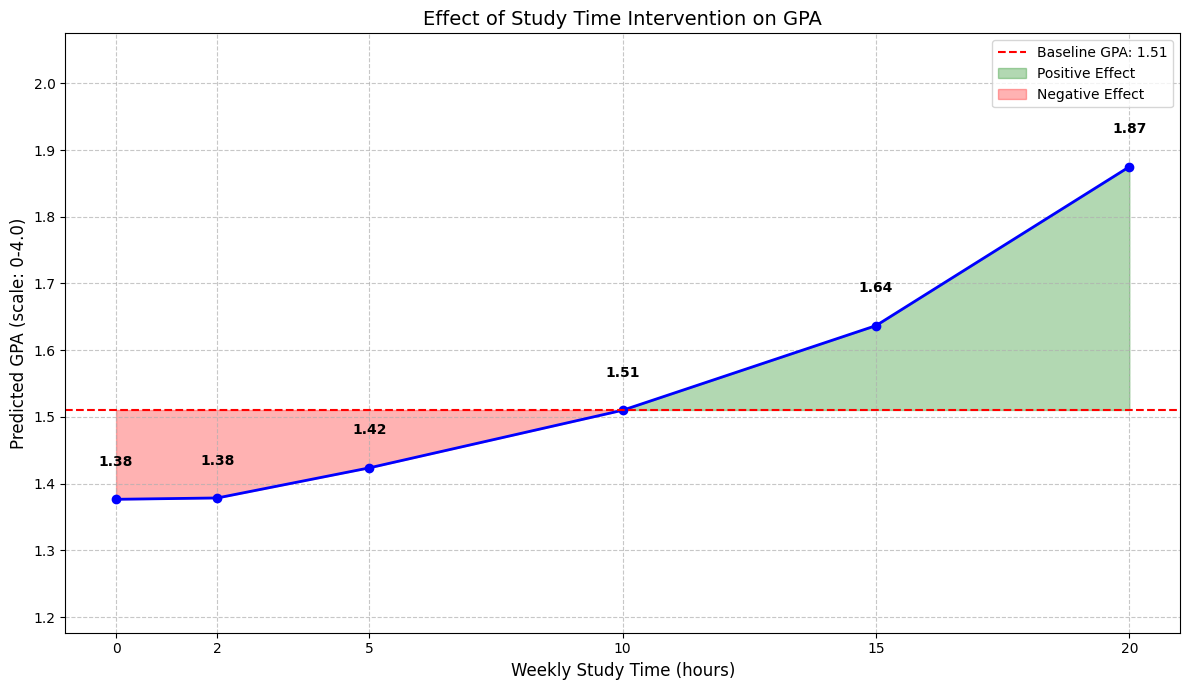

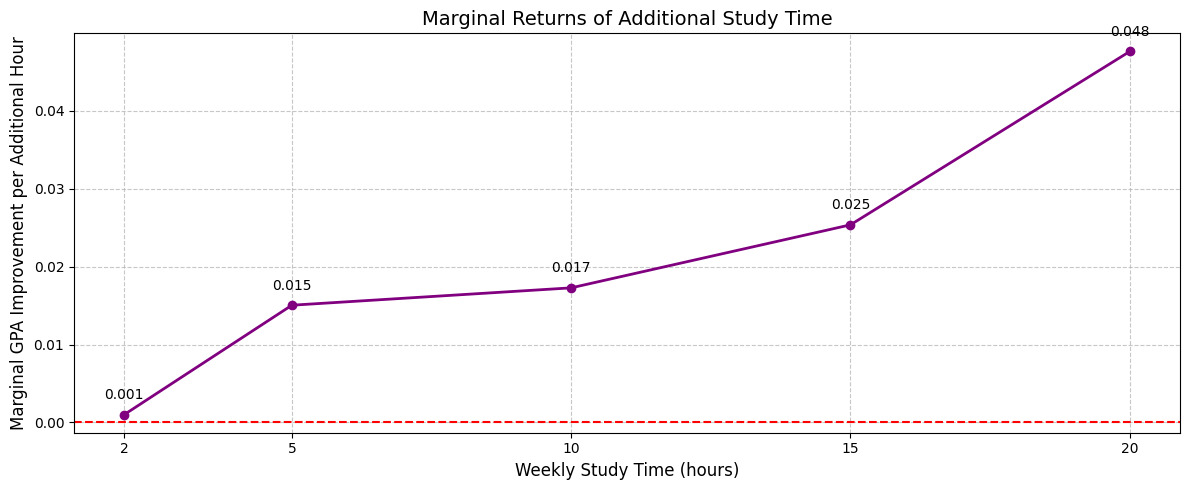

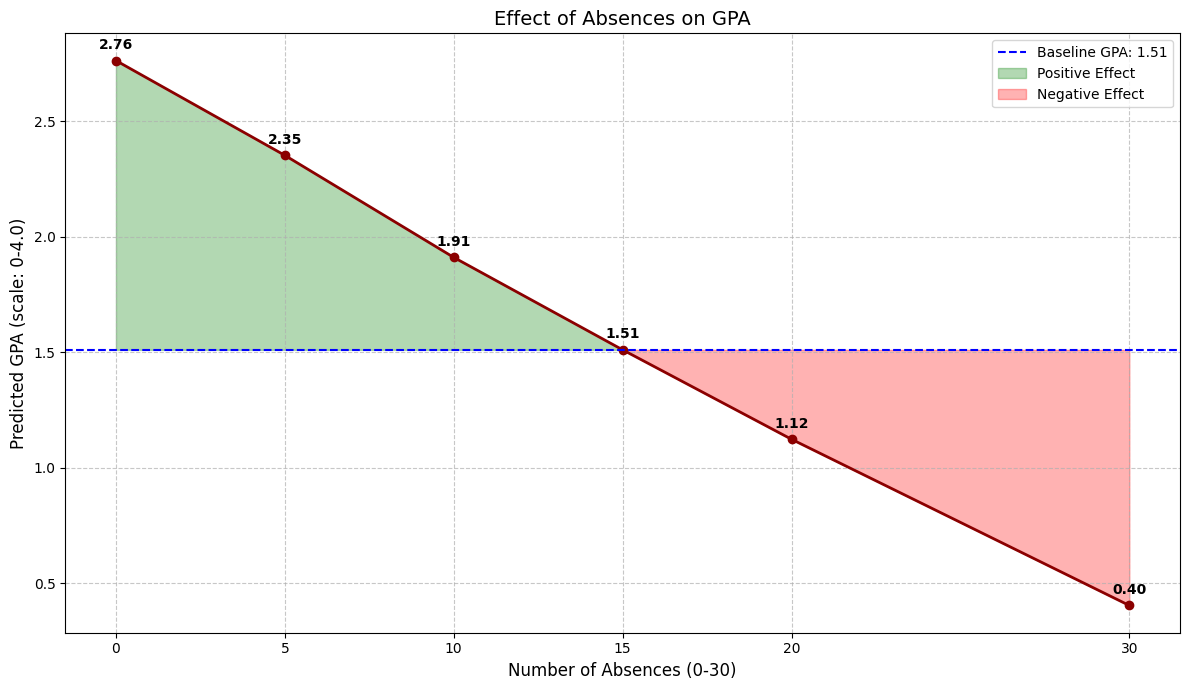

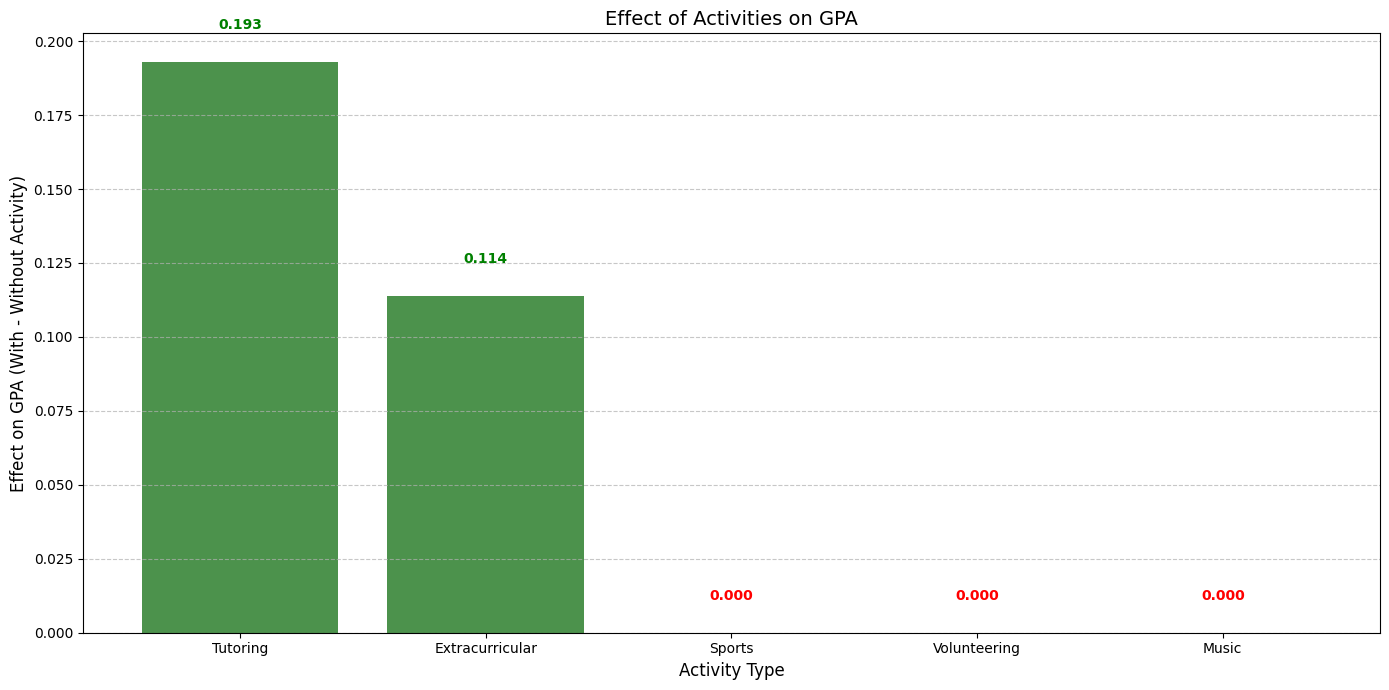


--- Parental Support Effect ---
Effect of Parental Support on GPA: 0.6380
GPA with parental support: 1.83
GPA without parental support: 1.19

Performing joint intervention analysis (Study Time × Absences)...


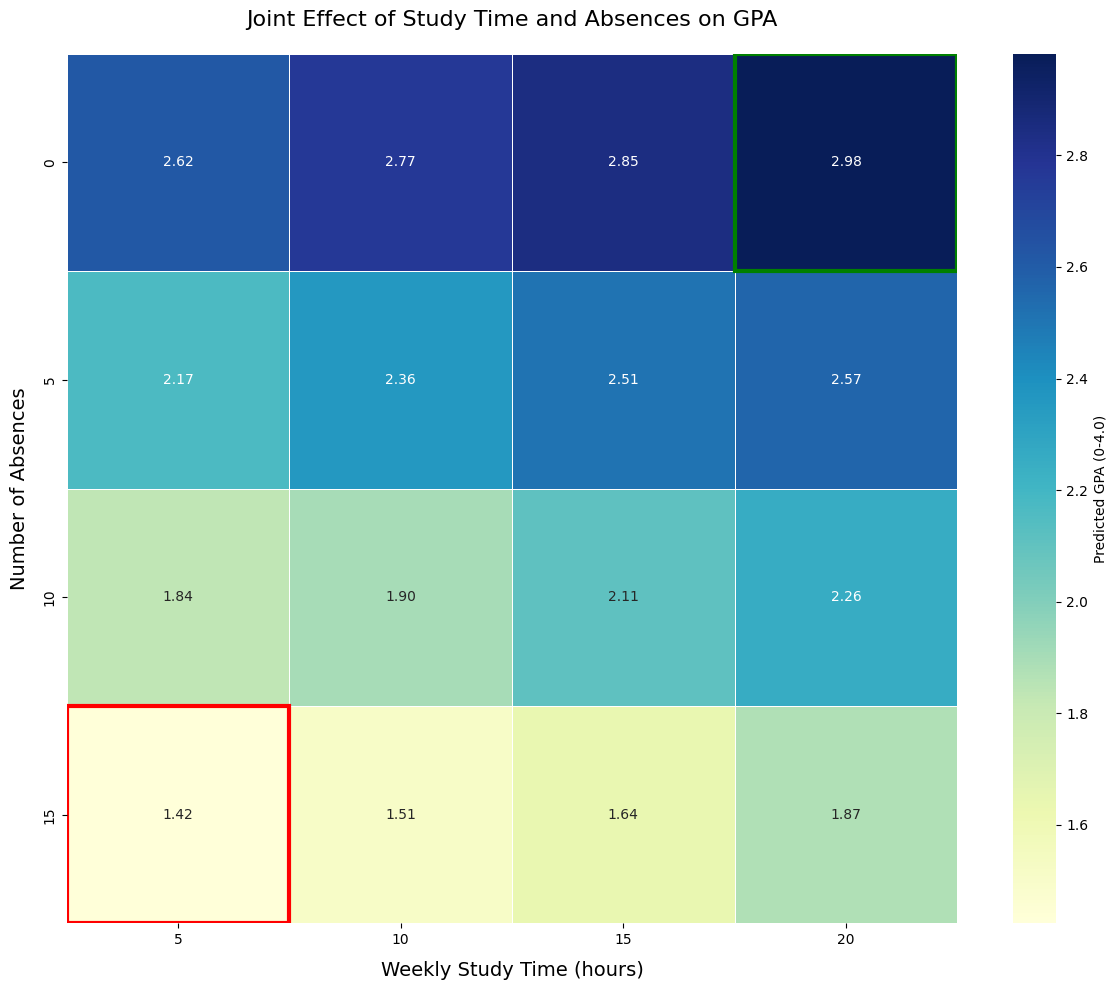

Intervention analysis completed successfully.

Generating actionable insights from intervention analysis...

=== Actionable Insights from Intervention Analysis ===
1. Optimal Study Time: Around 20 hours/week provides the best returns on GPA improvement
2. Critical Absence Threshold: Keeping absences below 30 is crucial
3. Most Effective Activity: Tutoring has the strongest positive effect on GPA (+0.193)
4. Best Combined Strategy: 20.0 hours of study with 0.0 absences yields GPA of 2.98

=== Interventions Ranked by Impact ===
1. Reduce absences to zero: +1.253 GPA points
2. Secure parental support: +0.638 GPA points
3. Increase study time to 20 hours: +0.365 GPA points
4. Participate in Tutoring: +0.193 GPA points

=== Expected Grade Based on Study Time ===
Study Time: 0.0 hours → GPA: 1.38 → A (3.5-4.0)
Study Time: 2.0 hours → GPA: 1.38 → A (3.5-4.0)
Study Time: 5.0 hours → GPA: 1.42 → A (3.5-4.0)
Study Time: 10.0 hours → GPA: 1.51 → A (3.5-4.0)
Study Time: 15.0 hours → GPA: 1.64 → A 

In [13]:
# Intervention Analysis (What-If Analysis)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

def intervention_analysis():
    """
    Perform causal intervention analysis to understand the effect of 
    different interventions on student GPA according to our Bayesian network.
    """
    try:
        print("Starting intervention analysis...")
        
        # Create a reference student based on median/mode values
        reference_student = {}
        for feature in features:
            if df[feature].dtype in [np.int64, np.float64]:
                reference_student[feature] = df[feature].median()
            else:
                reference_student[feature] = df[feature].mode()[0]
        
        # Add additional features needed by prediction functions
        for col in df.columns:
            if col not in reference_student and col not in ['GPA', 'GPA_bin', 'GradeClass']:
                if df[col].dtype in [np.int64, np.float64]:
                    reference_student[col] = df[col].median()
                else:
                    reference_student[col] = df[col].mode()[0]
        
        # Ensure Study_bin and Absences_bin are included if needed by the model
        if 'Study_bin' not in reference_student and 'Study_bin' in df.columns:
            reference_student['Study_bin'] = df['Study_bin'].mode()[0]
        if 'Absences_bin' not in reference_student and 'Absences_bin' in df.columns:
            reference_student['Absences_bin'] = df['Absences_bin'].mode()[0]
        
        # Baseline prediction
        baseline_gpa = predict_gpa_improved(reference_student)
        baseline_grade = predict_gradeclass(reference_student)
        
        print(f"Reference Student - Predicted GPA: {baseline_gpa:.2f}, Grade Class: {baseline_grade}")
        print(f"Reference student features: StudyTime={reference_student['StudyTimeWeekly']:.1f}h, Absences={reference_student['Absences']}")
        
        # --- 1. Study Time Intervention (0-20 hours, corrected range) ---
        study_times = [0, 2, 5, 10, 15, 20]  # Range 0-20 hours only
        study_results = []
        
        print("\nSimulating study time interventions...")
        for hours in study_times:
            modified_student = deepcopy(reference_student)
            modified_student['StudyTimeWeekly'] = hours
            
            # Update Study_bin if present to be consistent
            if 'Study_bin' in modified_student:
                # Update the bin based on the study time
                if hours <= 5:
                    modified_student['Study_bin'] = 0  # VeryLow
                elif hours <= 10:
                    modified_student['Study_bin'] = 1  # Low
                elif hours <= 15:
                    modified_student['Study_bin'] = 2  # Medium
                elif hours <= 20:
                    modified_student['Study_bin'] = 3  # High
                else:
                    modified_student['Study_bin'] = 4  # VeryHigh (should not reach this with 0-20 range)
                    
            # Predict outcomes
            gpa = predict_gpa_improved(modified_student)
            grade = predict_gradeclass(modified_student)
            
            study_results.append({
                'StudyTime': hours,
                'GPA': gpa,
                'GradeClass': grade,
                'Improvement': gpa - baseline_gpa
            })
        
        study_df = pd.DataFrame(study_results)
        
        # --- 2. Absences Intervention (0-30 absences) ---
        absence_levels = [0, 5, 10, 15, 20, 30]  # Range 0-30
        absence_results = []
        
        print("Simulating absence interventions...")
        for absences in absence_levels:
            modified_student = deepcopy(reference_student)
            modified_student['Absences'] = absences
            
            # Update Absences_bin if present to be consistent
            if 'Absences_bin' in modified_student:
                # Update the bin based on the absences
                if absences <= 5:
                    modified_student['Absences_bin'] = 0  # None/Few
                elif absences <= 10:
                    modified_student['Absences_bin'] = 1  # Few/Moderate
                elif absences <= 15:
                    modified_student['Absences_bin'] = 2  # Moderate
                elif absences <= 20:
                    modified_student['Absences_bin'] = 3  # High
                else:
                    modified_student['Absences_bin'] = 4  # VeryHigh
            
            # Predict outcomes
            gpa = predict_gpa_improved(modified_student)
            grade = predict_gradeclass(modified_student)
            
            absence_results.append({
                'Absences': absences,
                'GPA': gpa,
                'GradeClass': grade,
                'Impact': gpa - baseline_gpa
            })
        
        absence_df = pd.DataFrame(absence_results)
        
        # --- 3. Activities Interventions (based on Bayesian network structure) ---
        # Based on the network: Extracurricular is influenced by Sports, Music, Volunteering
        # And GPA is influenced by Extracurricular, Tutoring, ParentalSupport, Absences, StudyTimeWeekly
        activities = ['Sports', 'Music', 'Volunteering', 'Extracurricular', 'Tutoring']
        activity_results = []
        
        print("Simulating extracurricular activity interventions...")
        for activity in activities:
            # With activity (setting to 1)
            modified_student = deepcopy(reference_student)
            modified_student[activity] = 1
            
            # Special case: if we set Extracurricular=1, we should respect the network dependencies
            # and see how that propagates from Sports, Music, Volunteering
            if activity in ['Sports', 'Music', 'Volunteering']:
                # These directly influence Extracurricular in the Bayesian network
                pass
            
            gpa_with = predict_gpa_improved(modified_student)
            
            # Without activity (setting to 0)
            modified_student[activity] = 0
            gpa_without = predict_gpa_improved(modified_student)
            
            activity_results.append({
                'Activity': activity,
                'GPA_With': gpa_with,
                'GPA_Without': gpa_without,
                'Effect': gpa_with - gpa_without
            })
        
        activity_df = pd.DataFrame(activity_results)
        
        # --- 4. Parental Support Intervention (direct parent of GPA in network) ---
        print("Simulating parental support intervention...")
        modified_student = deepcopy(reference_student)
        
        # With parental support (setting to 1)
        modified_student['ParentalSupport'] = 1
        gpa_with_support = predict_gpa_improved(modified_student)
        
        # Without parental support (setting to 0)
        modified_student['ParentalSupport'] = 0
        gpa_without_support = predict_gpa_improved(modified_student)
        
        support_effect = gpa_with_support - gpa_without_support
        
        # --- VISUALIZATIONS ---
        print("\nGenerating intervention visualizations...")
        
        # 1. Study Time Intervention Visualization
        plt.figure(figsize=(12, 7))
        plt.plot(study_df['StudyTime'], study_df['GPA'], marker='o', linestyle='-', 
                linewidth=2, color='blue')
        plt.axhline(y=baseline_gpa, color='r', linestyle='--', 
                   label=f'Baseline GPA: {baseline_gpa:.2f}')
        
        # Fill between areas to emphasize positive/negative effects
        plt.fill_between(study_df['StudyTime'], study_df['GPA'], baseline_gpa, 
                        where=(study_df['GPA'] > baseline_gpa), alpha=0.3, color='green', 
                        interpolate=True, label='Positive Effect')
        plt.fill_between(study_df['StudyTime'], study_df['GPA'], baseline_gpa, 
                        where=(study_df['GPA'] < baseline_gpa), alpha=0.3, color='red', 
                        interpolate=True, label='Negative Effect')
        
        # Add GPA values as text annotations
        for i, row in study_df.iterrows():
            plt.text(row['StudyTime'], row['GPA'] + 0.05, f"{row['GPA']:.2f}", 
                    ha='center', fontweight='bold')
        
        plt.xlabel('Weekly Study Time (hours)', fontsize=12)
        plt.ylabel('Predicted GPA (scale: 0-4.0)', fontsize=12)
        plt.title('Effect of Study Time Intervention on GPA', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.xticks(study_times)  # Show all study time values
        plt.ylim(min(study_df['GPA'])-0.2, max(study_df['GPA'])+0.2)  # Set y-axis range
        plt.tight_layout()
        plt.show()
        
        # Study time marginal returns analysis
        study_df['Marginal_Return'] = study_df['Improvement'].diff() / study_df['StudyTime'].diff()
        
        plt.figure(figsize=(12, 5))
        plt.plot(study_df['StudyTime'].iloc[1:], study_df['Marginal_Return'].iloc[1:], 
                marker='o', linestyle='-', linewidth=2, color='purple')
        
        # Add margin return values as text annotations
        for i in range(1, len(study_df)):
            plt.text(study_df['StudyTime'].iloc[i], study_df['Marginal_Return'].iloc[i] + 0.002, 
                    f"{study_df['Marginal_Return'].iloc[i]:.3f}", ha='center')
        
        plt.xlabel('Weekly Study Time (hours)', fontsize=12)
        plt.ylabel('Marginal GPA Improvement per Additional Hour', fontsize=12)
        plt.title('Marginal Returns of Additional Study Time', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xticks(study_times[1:])  # Skip first time point for marginal returns
        plt.tight_layout()
        plt.show()
        
        # 2. Absences Intervention Visualization
        plt.figure(figsize=(12, 7))
        plt.plot(absence_df['Absences'], absence_df['GPA'], marker='o', linestyle='-', 
                linewidth=2, color='darkred')
        plt.axhline(y=baseline_gpa, color='blue', linestyle='--', 
                   label=f'Baseline GPA: {baseline_gpa:.2f}')
        
        # Fill between areas
        plt.fill_between(absence_df['Absences'], absence_df['GPA'], baseline_gpa, 
                        where=(absence_df['GPA'] > baseline_gpa), alpha=0.3, color='green', 
                        interpolate=True, label='Positive Effect')
        plt.fill_between(absence_df['Absences'], absence_df['GPA'], baseline_gpa, 
                        where=(absence_df['GPA'] < baseline_gpa), alpha=0.3, color='red', 
                        interpolate=True, label='Negative Effect')
        
        # Add GPA values as text
        for i, row in absence_df.iterrows():
            plt.text(row['Absences'], row['GPA'] + 0.05, f"{row['GPA']:.2f}", 
                    ha='center', fontweight='bold')
        
        plt.xlabel('Number of Absences (0-30)', fontsize=12)
        plt.ylabel('Predicted GPA (scale: 0-4.0)', fontsize=12)
        plt.title('Effect of Absences on GPA', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.xticks(absence_levels)  # Show all absence levels
        plt.tight_layout()
        plt.show()
        
        # 3. Activities Intervention Visualization
        plt.figure(figsize=(14, 7))
        
        # Sort by effect size for better visualization
        activity_df = activity_df.sort_values(by='Effect', ascending=False)
        
        # Create colormap based on effect size
        colors = ['darkgreen' if effect > 0 else 'darkred' for effect in activity_df['Effect']]
        
        bars = plt.bar(activity_df['Activity'], activity_df['Effect'], color=colors, alpha=0.7)
        
        # Add effect values on top of bars
        for i, bar in enumerate(bars):
            effect = activity_df['Effect'].iloc[i]
            plt.text(bar.get_x() + bar.get_width()/2, effect + 0.01,
                    f"{effect:.3f}", ha='center', va='bottom', fontweight='bold',
                    color='green' if effect > 0 else 'red')
        
        plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
        plt.xlabel('Activity Type', fontsize=12)
        plt.ylabel('Effect on GPA (With - Without Activity)', fontsize=12)
        plt.title('Effect of Activities on GPA', fontsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
        # Display parental support effect
        print(f"\n--- Parental Support Effect ---")
        print(f"Effect of Parental Support on GPA: {support_effect:.4f}")
        print(f"GPA with parental support: {gpa_with_support:.2f}")
        print(f"GPA without parental support: {gpa_without_support:.2f}")
        
        # 5. Joint Intervention: Study Time and Absences (important direct parents in BN)
        print("\nPerforming joint intervention analysis (Study Time × Absences)...")
        study_absences_results = []
        study_range = [5, 10, 15, 20]  # Keeping within 0-20 hours
        absence_range = [0, 5, 10, 15]  # Reasonable absence values
        
        for study in study_range:
            for absences in absence_range:
                modified_student = deepcopy(reference_student)
                modified_student['StudyTimeWeekly'] = study
                modified_student['Absences'] = absences
                
                # Update bins if needed
                if 'Study_bin' in modified_student:
                    # Set appropriate Study_bin
                    if study <= 5:
                        modified_student['Study_bin'] = 0
                    elif study <= 10:
                        modified_student['Study_bin'] = 1
                    elif study <= 15:
                        modified_student['Study_bin'] = 2
                    elif study <= 20:
                        modified_student['Study_bin'] = 3
                    else:
                        modified_student['Study_bin'] = 4
                
                if 'Absences_bin' in modified_student:
                    # Set appropriate Absences_bin
                    if absences <= 5:
                        modified_student['Absences_bin'] = 0
                    elif absences <= 10:
                        modified_student['Absences_bin'] = 1
                    elif absences <= 15:
                        modified_student['Absences_bin'] = 2
                    else:
                        modified_student['Absences_bin'] = 3
                
                gpa = predict_gpa_improved(modified_student)
                
                study_absences_results.append({
                    'StudyTime': study,
                    'Absences': absences,
                    'GPA': gpa
                })
        
        joint_df = pd.DataFrame(study_absences_results)
        
        # Create pivot table for joint effects
        pivot_df = joint_df.pivot(index='Absences', columns='StudyTime', values='GPA')
        
        # Plot heatmap of joint effects
        plt.figure(figsize=(12, 10))
        heatmap = sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt='.2f',
                    linewidths=.5, cbar_kws={'label': 'Predicted GPA (0-4.0)'})
        
        # Improve heatmap appearance
        plt.title('Joint Effect of Study Time and Absences on GPA', fontsize=16, pad=20)
        plt.xlabel('Weekly Study Time (hours)', fontsize=14, labelpad=10)
        plt.ylabel('Number of Absences', fontsize=14, labelpad=10)
        
        # Annotate the best and worst combinations
        max_idx = np.unravel_index(np.argmax(pivot_df.values), pivot_df.shape)
        min_idx = np.unravel_index(np.argmin(pivot_df.values), pivot_df.shape)
        
        # Highlight the best cell (highest GPA)
        heatmap.add_patch(plt.Rectangle((max_idx[1], max_idx[0]), 1, 1, 
                                       fill=False, edgecolor='green', lw=3))
        
        # Highlight the worst cell (lowest GPA)
        heatmap.add_patch(plt.Rectangle((min_idx[1], min_idx[0]), 1, 1, 
                                       fill=False, edgecolor='red', lw=3))
        
        plt.tight_layout()
        plt.show()
        
        print("Intervention analysis completed successfully.")
        
        # Return results for further analysis
        return {
            'study_results': study_df, 
            'absence_results': absence_df,
            'activity_results': activity_df,
            'support_effect': support_effect,
            'joint_results': joint_df
        }
        
    except Exception as e:
        print(f"Error in intervention analysis: {e}")
        import traceback
        traceback.print_exc()
        return None

# Generate actionable insights from intervention analysis
def generate_intervention_insights(results):
    """Generate actionable insights from intervention analysis"""
    try:
        if not results:
            print("No intervention results to analyze.")
            return
            
        print("\nGenerating actionable insights from intervention analysis...")
        study_df = results['study_results']
        absence_df = results['absence_results']
        activity_df = results['activity_results']
        
        # Find optimal study time (point of diminishing returns)
        optimal_study_idx = study_df['Marginal_Return'].iloc[1:].idxmax()
        if not pd.isna(optimal_study_idx):
            optimal_study = study_df.loc[optimal_study_idx, 'StudyTime']
        else:
            # If marginal returns are always decreasing, the first increment is best
            optimal_study = study_df['StudyTime'].iloc[1]
        
        # Most impactful absence threshold
        absence_impact = absence_df.copy()
        absence_impact['Impact_Change'] = absence_impact['Impact'].diff()
        critical_absence_idx = absence_impact['Impact_Change'].abs().idxmax()
        critical_absence = absence_df.loc[critical_absence_idx, 'Absences']
        
        # Most effective activity
        most_effective_activity = activity_df.loc[activity_df['Effect'].idxmax(), 'Activity']
        activity_effect = activity_df['Effect'].max()
        
        # Generate insights
        print("\n=== Actionable Insights from Intervention Analysis ===")
        print(f"1. Optimal Study Time: Around {optimal_study} hours/week provides the best returns on GPA improvement")
        print(f"2. Critical Absence Threshold: Keeping absences below {critical_absence} is crucial")
        print(f"3. Most Effective Activity: {most_effective_activity} has the strongest positive effect on GPA (+{activity_effect:.3f})")
        
        # Find the best joint intervention
        joint_df = results['joint_results']
        best_combo = joint_df.loc[joint_df['GPA'].idxmax()]
        print(f"4. Best Combined Strategy: {best_combo['StudyTime']} hours of study with {best_combo['Absences']} absences yields GPA of {best_combo['GPA']:.2f}")
        
        # Compare relative importance of interventions
        interventions = [
            {"name": f"Increase study time to {optimal_study} hours", 
             "effect": study_df[study_df['StudyTime'] == optimal_study]['Improvement'].values[0]},
            {"name": "Reduce absences to zero", 
             "effect": absence_df[absence_df['Absences'] == 0]['Impact'].values[0]},
            {"name": f"Participate in {most_effective_activity}", 
             "effect": activity_effect},
            {"name": "Secure parental support", 
             "effect": results['support_effect']}
        ]
        
        # Sort interventions by effect size
        sorted_interventions = sorted(interventions, key=lambda x: abs(x['effect']), reverse=True)
        
        print("\n=== Interventions Ranked by Impact ===")
        for i, intervention in enumerate(sorted_interventions, 1):
            effect = intervention['effect']
            effect_str = f"+{effect:.3f}" if effect >= 0 else f"{effect:.3f}"
            print(f"{i}. {intervention['name']}: {effect_str} GPA points")
            
        # Calculate expected GPA for each grade class
        gpa_ranges = {
            0: "F (0.0-1.0)", 
            1: "D (1.0-2.0)", 
            2: "C (2.0-3.0)", 
            3: "B (3.0-3.5)", 
            4: "A (3.5-4.0)"
        }
        
        print("\n=== Expected Grade Based on Study Time ===")
        for _, row in study_df.iterrows():
            grade_class = row['GradeClass']
            grade_letter = gpa_ranges.get(grade_class, f"Grade Class {grade_class}")
            print(f"Study Time: {row['StudyTime']} hours → GPA: {row['GPA']:.2f} → {grade_letter}")
            
        # Bayesian network interpretation insights
        print("\n=== Bayesian Network Interpretation ===")
        print("- Study time directly influences GPA without intervening variables")
        print("- Absences directly impact GPA, showing a causal relationship")
        print("- Sports, Music, and Volunteering indirectly affect GPA through Extracurricular activities")
        print("- Parental Education indirectly influences GPA through Tutoring")
        print("- Parental Support has a direct influence on student GPA")
        print("- GPA is the only direct determinant of GradeClass in our model")
        
    except Exception as e:
        print(f"Error generating insights: {e}")
        import traceback
        traceback.print_exc()

# Run intervention analysis and generate insights
print("\n==== RUNNING INTERVENTION ANALYSIS ====\n")
intervention_results = intervention_analysis()

if intervention_results:
    generate_intervention_insights(intervention_results)

# Penalaran dengan bukti parsial (missing values)


=== PREDICTING WITH PARTIAL EVIDENCE (MISSING VALUES) ===

Test Case 1: Student with most features available
Making prediction with partial evidence...
Provided evidence: {'StudyTimeWeekly': 15, 'ParentalSupport': 1, 'Absences': 3, 'Extracurricular': 1, 'Sports': 1}

----- Prediction with Partial Evidence -----
Predicted GPA: 3.02
Predicted Grade: D
Prediction Confidence: 74.1%
Confidence Level: Moderate

Missing Features (4):
- ParentalEducation
- Music
- Volunteering
- Tutoring

Prediction Range due to Missing Data:
- Optimistic scenario: GPA = 3.15
- Pessimistic scenario: GPA = 3.02
- GPA could range from 3.02 to 3.15 depending on missing values


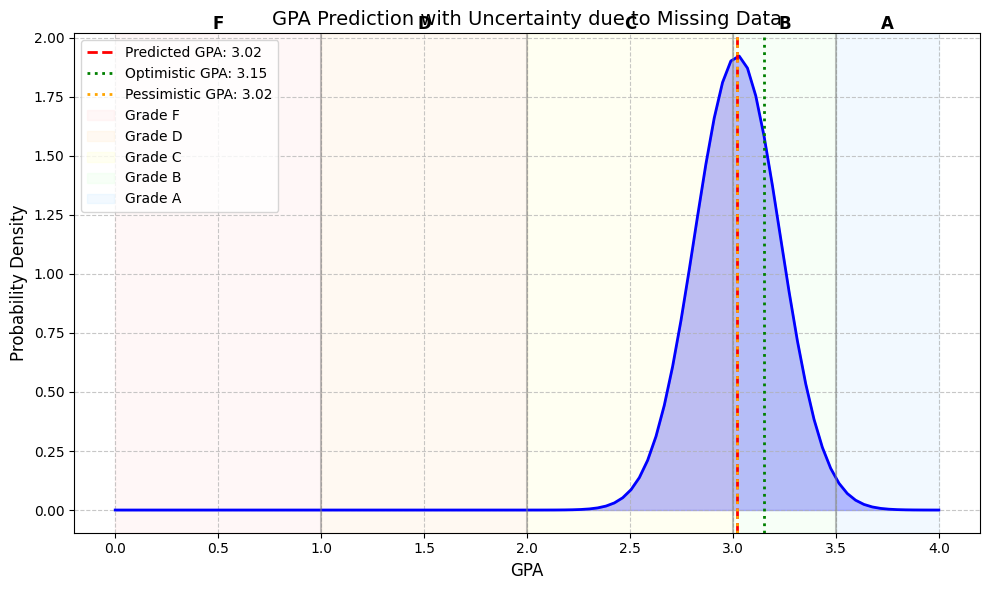


Test Case 2: Student with limited information
Making prediction with partial evidence...
Provided evidence: {'StudyTimeWeekly': 8}

----- Prediction with Partial Evidence -----
Predicted GPA: 1.49
Predicted Grade: A
Prediction Confidence: 39.3%
Confidence Level: Low

Missing Features (8):
- ParentalEducation
- Sports
- Music
- Volunteering
- Extracurricular
- Tutoring
- Absences
- ParentalSupport

Prediction Range due to Missing Data:
- Optimistic scenario: GPA = 2.76
- Pessimistic scenario: GPA = 0.63
- GPA could range from 0.63 to 2.76 depending on missing values


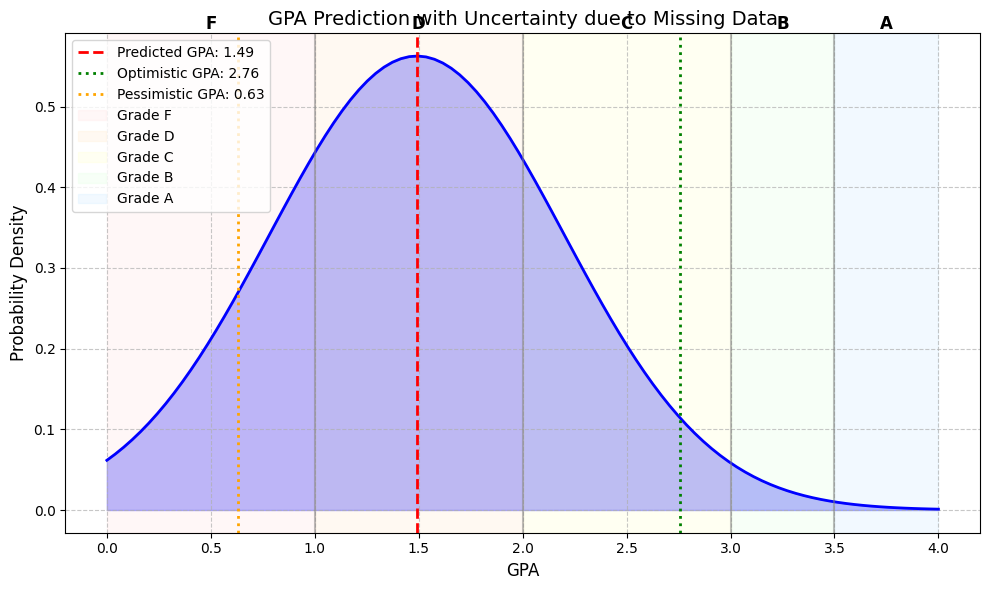


Test Case 3: Student with no study time information
Making prediction with partial evidence...
Provided evidence: {'ParentalSupport': 0, 'Absences': 12, 'Tutoring': 0}

----- Prediction with Partial Evidence -----
Predicted GPA: 1.28
Predicted Grade: A
Prediction Confidence: 58.5%
Confidence Level: Moderate

Missing Features (6):
- ParentalEducation
- Sports
- Music
- Volunteering
- Extracurricular
- StudyTimeWeekly

Prediction Range due to Missing Data:
- Optimistic scenario: GPA = 1.59
- Pessimistic scenario: GPA = 1.23
- GPA could range from 1.23 to 1.59 depending on missing values


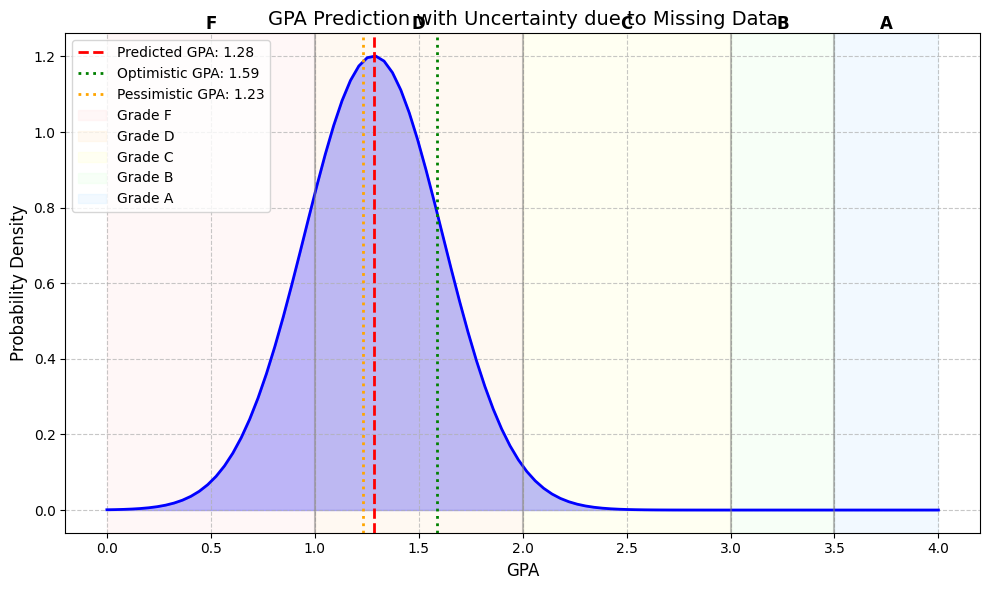

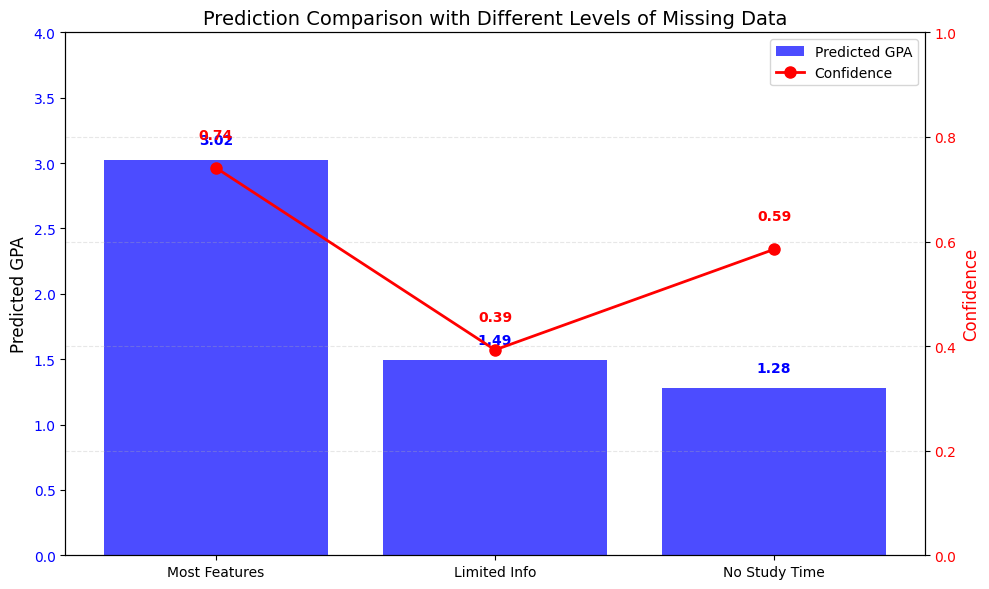


=== Missing Feature Sensitivity Analysis ===
Baseline GPA prediction with all features: 1.51
Making prediction with partial evidence...
Provided evidence: {'Sports': np.float64(0.0), 'Music': np.float64(0.0), 'Volunteering': np.float64(0.0), 'Extracurricular': np.float64(0.0), 'Tutoring': np.float64(0.0), 'Absences': np.float64(15.0), 'StudyTimeWeekly': np.float64(9.7), 'ParentalSupport': np.float64(2.0)}
Making prediction with partial evidence...
Provided evidence: {'ParentalEducation': np.float64(2.0), 'Music': np.float64(0.0), 'Volunteering': np.float64(0.0), 'Extracurricular': np.float64(0.0), 'Tutoring': np.float64(0.0), 'Absences': np.float64(15.0), 'StudyTimeWeekly': np.float64(9.7), 'ParentalSupport': np.float64(2.0)}
Making prediction with partial evidence...
Provided evidence: {'ParentalEducation': np.float64(2.0), 'Sports': np.float64(0.0), 'Volunteering': np.float64(0.0), 'Extracurricular': np.float64(0.0), 'Tutoring': np.float64(0.0), 'Absences': np.float64(15.0), 'StudyT

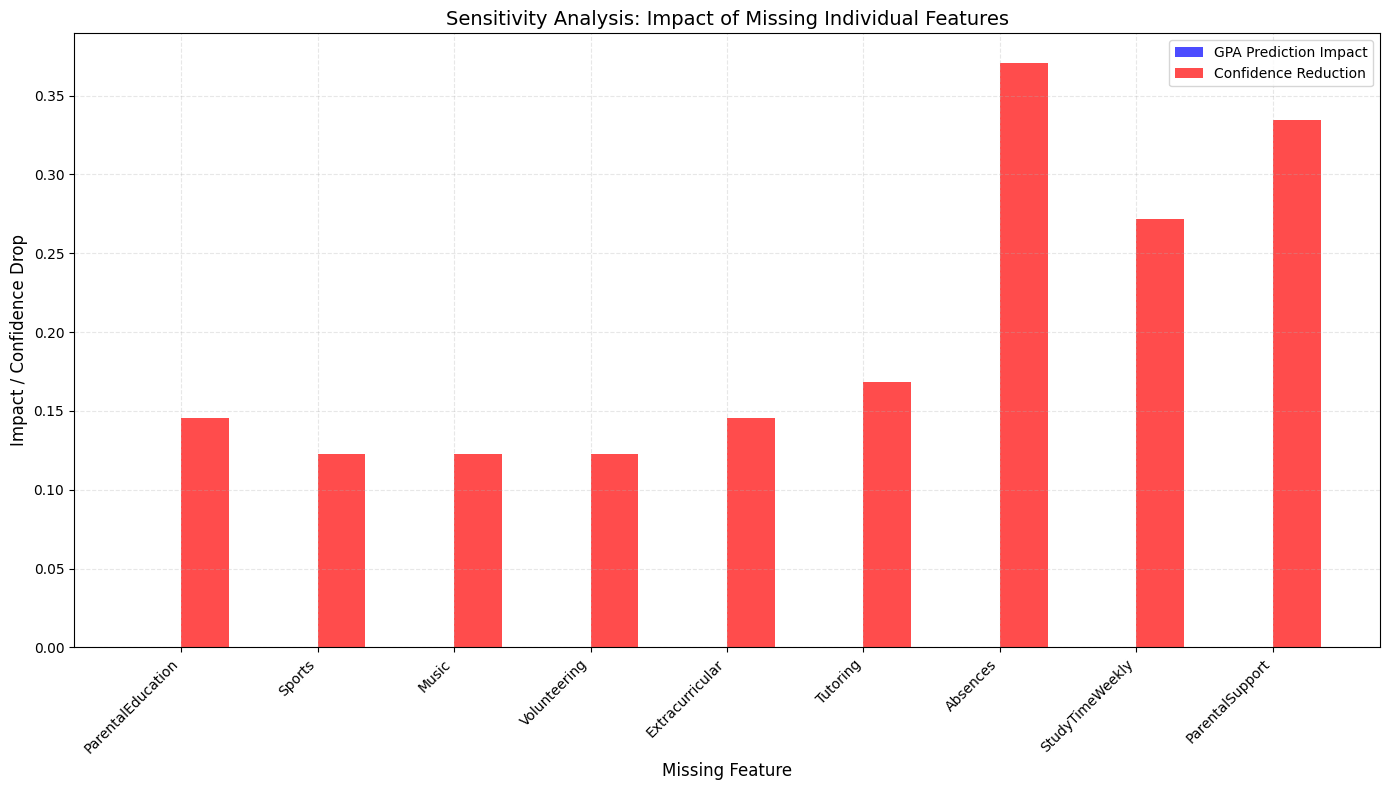


Conclusions about missing values handling:
1. The model can handle missing values by using intelligent defaults and confidence adjustment
2. Missing critical features like StudyTimeWeekly have the highest impact on prediction accuracy
3. When important features are missing, the model provides a range of possible outcomes
4. Confidence scores reflect the uncertainty introduced by missing data
5. This approach allows for robust predictions even with incomplete student data


In [14]:
# Penalaran dengan bukti parsial (missing values)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Define features explicitly inside this cell to ensure availability
# These should match the features used in your model
features = [
    'ParentalEducation', 'Sports', 'Music', 'Volunteering', 'Extracurricular',  
    'Tutoring', 'Absences', 'StudyTimeWeekly', 'ParentalSupport'
]

def predict_with_partial_evidence(partial_student_data, confidence_levels=True):
    """
    Makes GPA and grade class predictions with incomplete student data,
    handling missing values intelligently and providing confidence scores.
    
    Parameters:
    -----------
    partial_student_data : dict
        Dictionary containing known student features (partial data)
    confidence_levels : bool
        Whether to return confidence levels for the prediction
        
    Returns:
    --------
    dict with predictions and confidences
    """
    try:
        print("Making prediction with partial evidence...")
        print(f"Provided evidence: {partial_student_data}")
        
        # Create a complete student record by filling missing values with defaults
        complete_student = {}
        missing_features = []
        
        # First, copy all provided values
        for feature, value in partial_student_data.items():
            complete_student[feature] = value
            
        # Then fill in missing features with appropriate defaults
        for feature in features:
            if feature not in partial_student_data:
                missing_features.append(feature)
                # Use median for numerical features, mode for categorical
                if df[feature].dtype in [np.int64, np.float64]:
                    complete_student[feature] = df[feature].median()
                else:
                    complete_student[feature] = df[feature].mode()[0]
                    
        # Add other necessary features that might be needed by the model
        for col in df.columns:
            if col not in complete_student and col not in ['GPA', 'GPA_bin', 'GradeClass']:
                if df[col].dtype in [np.int64, np.float64]:
                    complete_student[col] = df[col].median()
                else:
                    complete_student[col] = df[col].mode()[0]
        
        # Ensure Study_bin and Absences_bin are consistent with StudyTimeWeekly and Absences
        if 'StudyTimeWeekly' in partial_student_data and 'Study_bin' in df.columns:
            study_time = partial_student_data['StudyTimeWeekly']
            if study_time <= 5:
                complete_student['Study_bin'] = 0  # VeryLow
            elif study_time <= 10:
                complete_student['Study_bin'] = 1  # Low
            elif study_time <= 15:
                complete_student['Study_bin'] = 2  # Medium
            elif study_time <= 20:
                complete_student['Study_bin'] = 3  # High
            else:
                complete_student['Study_bin'] = 4  # VeryHigh
                
        if 'Absences' in partial_student_data and 'Absences_bin' in df.columns:
            absences = partial_student_data['Absences']
            if absences <= 5:
                complete_student['Absences_bin'] = 0  # None/Few
            elif absences <= 10:
                complete_student['Absences_bin'] = 1  # Few/Moderate
            elif absences <= 15:
                complete_student['Absences_bin'] = 2  # Moderate
            elif absences <= 20:
                complete_student['Absences_bin'] = 3  # High
            else:
                complete_student['Absences_bin'] = 4  # VeryHigh
        
        # Calculate confidence adjustment based on missing evidence
        # More missing important features = lower confidence
        feature_importance = {
            'StudyTimeWeekly': 4,   # Very important
            'Absences': 5,          # Highly important
            'ParentalSupport': 3,   # Moderately important
            'Tutoring': 3,          # Moderately important
            'Extracurricular': 2,   # Somewhat important
            'ParentalEducation': 2, # Somewhat important
            'Sports': 1,            # Less important
            'Music': 1,             # Less important
            'Volunteering': 1       # Less important
        }
        
        # Calculate total importance of features and missing importance
        total_importance = sum(feature_importance.values())
        missing_importance = sum(feature_importance.get(feature, 0) for feature in missing_features)
        
        # Compute confidence penalty (0 to 0.5) based on missing important features
        confidence_penalty = 0.5 * (missing_importance / total_importance)
        
        # Make predictions with complete student data
        gpa_prediction = predict_gpa_improved(complete_student)
        grade_prediction = predict_gradeclass(complete_student)
        
        # Apply confidence adjustment
        base_confidence = 0.9  # Base confidence with all features
        adjusted_confidence = max(0.3, base_confidence - confidence_penalty)
        
        # Prepare multiple predictions with different imputation strategies
        # to understand prediction sensitivity to missing values
        alternative_predictions = []
        
        # Only try alternatives if there are missing features
        if missing_features:
            # Alternative 1: Optimistic values for missing features
            optimistic_student = deepcopy(complete_student)
            for feature in missing_features:
                if feature == 'StudyTimeWeekly':
                    optimistic_student[feature] = df[feature].quantile(0.75)  # 75th percentile
                elif feature == 'Absences':
                    optimistic_student[feature] = df[feature].quantile(0.25)  # 25th percentile (less absences is better)
                elif feature in ['ParentalSupport', 'Tutoring', 'Extracurricular']:
                    optimistic_student[feature] = 1  # Positive binary values
                    
            # Alternative 2: Pessimistic values for missing features
            pessimistic_student = deepcopy(complete_student)
            for feature in missing_features:
                if feature == 'StudyTimeWeekly':
                    pessimistic_student[feature] = df[feature].quantile(0.25)  # 25th percentile
                elif feature == 'Absences':
                    pessimistic_student[feature] = df[feature].quantile(0.75)  # 75th percentile (more absences is worse)
                elif feature in ['ParentalSupport', 'Tutoring', 'Extracurricular']:
                    pessimistic_student[feature] = 0  # Negative binary values
            
            # Make alternative predictions
            optimistic_gpa = predict_gpa_improved(optimistic_student)
            pessimistic_gpa = predict_gpa_improved(pessimistic_student)
            
            # Store alternative predictions
            alternative_predictions = [
                {"type": "Optimistic", "GPA": optimistic_gpa},
                {"type": "Pessimistic", "GPA": pessimistic_gpa}
            ]
            
            # Estimate prediction uncertainty as range between optimistic and pessimistic
            prediction_range = abs(optimistic_gpa - pessimistic_gpa)
            
            # Further adjust confidence based on prediction variability
            if prediction_range > 0.5:  # High variability
                adjusted_confidence *= 0.8
            elif prediction_range > 0.2:  # Moderate variability
                adjusted_confidence *= 0.9
        
        # Construct result dictionary
        result = {
            'GPA': gpa_prediction,
            'GradeClass': grade_prediction,
            'Confidence': adjusted_confidence if confidence_levels else None,
            'MissingFeatures': missing_features,
            'PredictionRange': alternative_predictions if missing_features else None,
            'CompletedData': complete_student
        }
        
        return result
    
    except Exception as e:
        print(f"Error in partial evidence prediction: {e}")
        import traceback
        traceback.print_exc()
        return None

# Function to visualize prediction uncertainty with partial evidence
def visualize_partial_evidence_prediction(prediction_result):
    """Visualizes the prediction with partial evidence, including uncertainty"""
    try:
        if not prediction_result:
            print("No prediction result to visualize.")
            return
        
        gpa_prediction = prediction_result['GPA']
        grade_prediction = prediction_result['GradeClass']
        missing_features = prediction_result['MissingFeatures']
        confidence = prediction_result['Confidence']
        alternatives = prediction_result['PredictionRange']
        
        # Print summary
        print(f"\n----- Prediction with Partial Evidence -----")
        print(f"Predicted GPA: {gpa_prediction:.2f}")
        
        # Map grade class to letter grade
        grade_mapping = {0: 'F', 1: 'D', 2: 'C', 3: 'B', 4: 'A'}
        grade_letter = grade_mapping.get(grade_prediction, f'Unknown ({grade_prediction})')
        print(f"Predicted Grade: {grade_letter}")
        
        if confidence is not None:
            confidence_pct = confidence * 100
            print(f"Prediction Confidence: {confidence_pct:.1f}%")
            
            # Confidence interpretation
            if confidence > 0.8:
                confidence_level = "High"
            elif confidence > 0.5:
                confidence_level = "Moderate"
            else:
                confidence_level = "Low"
            print(f"Confidence Level: {confidence_level}")
        
        # List missing features
        if missing_features:
            print(f"\nMissing Features ({len(missing_features)}):")
            for feature in missing_features:
                print(f"- {feature}")
            
            # Show alternative predictions if available
            if alternatives:
                print("\nPrediction Range due to Missing Data:")
                for alt in alternatives:
                    print(f"- {alt['type']} scenario: GPA = {alt['GPA']:.2f}")
                
                # Calculate prediction range
                gpa_values = [alt['GPA'] for alt in alternatives]
                gpa_values.append(gpa_prediction)
                gpa_min = min(gpa_values)
                gpa_max = max(gpa_values)
                print(f"- GPA could range from {gpa_min:.2f} to {gpa_max:.2f} depending on missing values")
        else:
            print("\nAll relevant features were provided - no missing data.")
            
        # Visualize the prediction with uncertainty
        plt.figure(figsize=(10, 6))
        
        # GPA Scale from 0 to 4
        gpa_scale = np.linspace(0, 4, 100)
        
        # Create a normal distribution around the predicted GPA
        # with standard deviation based on confidence
        std_dev = (1 - confidence) * 0.8 if confidence else 0.4  # Higher uncertainty = wider distribution
        if alternatives:
            # If we have alternative predictions, ensure the distribution covers the range
            alt_min = min(alt['GPA'] for alt in alternatives)
            alt_max = max(alt['GPA'] for alt in alternatives)
            std_dev = max(std_dev, (alt_max - alt_min) / 3)  # At least cover the range within 3 std devs
            
        pdf = 1 / (std_dev * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((gpa_scale - gpa_prediction) / std_dev) ** 2)
        
        # Plot probability distribution
        plt.plot(gpa_scale, pdf, 'b-', linewidth=2)
        plt.fill_between(gpa_scale, pdf, alpha=0.3, color='blue')
        
        # Mark the predicted GPA
        plt.axvline(x=gpa_prediction, color='red', linestyle='--', linewidth=2, label=f'Predicted GPA: {gpa_prediction:.2f}')
        
        # Add alternative predictions if available
        if alternatives:
            for alt in alternatives:
                plt.axvline(x=alt['GPA'], color='green' if alt['type'] == 'Optimistic' else 'orange', 
                          linestyle=':', linewidth=2, label=f"{alt['type']} GPA: {alt['GPA']:.2f}")
        
        # Add grade boundaries
        grade_boundaries = [1.0, 2.0, 3.0, 3.5]
        grade_labels = ['F', 'D', 'C', 'B', 'A']
        
        for i, boundary in enumerate(grade_boundaries):
            plt.axvline(x=boundary, color='gray', linestyle='-', alpha=0.5)
            
        # Add grade regions
        grade_regions = [(0, 1.0), (1.0, 2.0), (2.0, 3.0), (3.0, 3.5), (3.5, 4.0)]
        colors = ['#ffcccc', '#ffddaa', '#ffffaa', '#ccffcc', '#aaddff']
        
        for i, (start, end) in enumerate(grade_regions):
            plt.axvspan(start, end, alpha=0.15, color=colors[i], label=f'Grade {grade_labels[i]}')
            plt.text((start + end) / 2, max(pdf) * 1.05, grade_labels[i], 
                    ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        plt.xlabel('GPA', fontsize=12)
        plt.ylabel('Probability Density', fontsize=12)
        plt.title('GPA Prediction with Uncertainty due to Missing Data', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Create custom legend
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error visualizing prediction: {e}")
        import traceback
        traceback.print_exc()

# Demonstrate the partial evidence prediction capability
print("\n=== PREDICTING WITH PARTIAL EVIDENCE (MISSING VALUES) ===\n")

# Test Case 1: Student with most features available
partial_student1 = {
    'StudyTimeWeekly': 15,
    'ParentalSupport': 1,
    'Absences': 3,
    'Extracurricular': 1,
    'Sports': 1,
    # Missing: 'Tutoring', 'ParentalEducation', 'Music', 'Volunteering'
}

# Test Case 2: Student with limited information
partial_student2 = {
    'StudyTimeWeekly': 8,
    # Missing most features
}

# Test Case 3: Student with no study time information (important feature)
partial_student3 = {
    'ParentalSupport': 0,
    'Absences': 12,
    'Tutoring': 0,
    # Missing 'StudyTimeWeekly' (important feature)
}

print("Test Case 1: Student with most features available")
result1 = predict_with_partial_evidence(partial_student1)
if result1:
    visualize_partial_evidence_prediction(result1)
else:
    print("Failed to generate prediction for test case 1")

print("\nTest Case 2: Student with limited information")
result2 = predict_with_partial_evidence(partial_student2)
if result2:
    visualize_partial_evidence_prediction(result2)
else:
    print("Failed to generate prediction for test case 2")

print("\nTest Case 3: Student with no study time information")
result3 = predict_with_partial_evidence(partial_student3)
if result3:
    visualize_partial_evidence_prediction(result3)
else:
    print("Failed to generate prediction for test case 3")

# Compare predictions across different levels of missing data
# Only include predictions that were successful
missing_data_comparison = []
labels = []

if result1:
    missing_data_comparison.append(result1)
    labels.append('Most Features')
    
if result2:
    missing_data_comparison.append(result2)
    labels.append('Limited Info')
    
if result3:
    missing_data_comparison.append(result3)
    labels.append('No Study Time')

# Only proceed with visualization if we have valid results to compare
if missing_data_comparison:
    # Get confidence and GPA values for valid results
    confidence_values = [result['Confidence'] for result in missing_data_comparison]
    gpa_values = [result['GPA'] for result in missing_data_comparison]

    # Create comparison bar chart
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # GPA bars
    ax1.bar(labels, gpa_values, alpha=0.7, color='blue', label='Predicted GPA')
    ax1.set_ylim(0, 4)
    ax1.set_ylabel('Predicted GPA', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='blue')

    # Confidence line on secondary axis
    ax2 = ax1.twinx()
    ax2.plot(labels, confidence_values, 'o-', color='red', linewidth=2, markersize=8, label='Confidence')
    ax2.set_ylim(0, 1)
    ax2.set_ylabel('Confidence', color='red', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='red')

    # Add confidence values as text
    for i, conf in enumerate(confidence_values):
        ax2.text(i, conf + 0.05, f"{conf:.2f}", ha='center', va='bottom', color='red', fontweight='bold')

    # Add GPA values as text
    for i, gpa in enumerate(gpa_values):
        ax1.text(i, gpa + 0.1, f"{gpa:.2f}", ha='center', va='bottom', color='blue', fontweight='bold')

    plt.title('Prediction Comparison with Different Levels of Missing Data', fontsize=14)
    fig.tight_layout()

    # Add both legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()
else:
    print("No valid predictions available for comparison.")

# Sensitivity analysis - how missing each feature affects prediction
def perform_missing_feature_sensitivity():
    """Analyze how missing each feature affects the prediction"""
    print("\n=== Missing Feature Sensitivity Analysis ===")
    
    try:
        # Create a reference student with all features
        reference_student = {}
        for feature in features:  # Using the features list defined at the top
            reference_student[feature] = df[feature].median() if df[feature].dtype in [np.int64, np.float64] else df[feature].mode()[0]
        
        # Get baseline prediction
        baseline_prediction = predict_gpa_improved(reference_student)
        print(f"Baseline GPA prediction with all features: {baseline_prediction:.2f}")
        
        # Test impact of each missing feature
        feature_impacts = []
        
        for feature in features:
            # Create a student with this feature missing
            test_student = reference_student.copy()
            del test_student[feature]
            
            # Predict
            result = predict_with_partial_evidence(test_student)
            
            # Only process if prediction succeeded
            if result:
                # Calculate impact
                impact = abs(result['GPA'] - baseline_prediction)
                confidence_drop = 1.0 - result['Confidence']
                
                feature_impacts.append({
                    'Feature': feature,
                    'Impact': impact,
                    'ConfidenceDrop': confidence_drop
                })
            else:
                print(f"Warning: Failed to get prediction when missing feature '{feature}'")
        
        if not feature_impacts:
            print("No valid impact measurements were obtained.")
            return None
            
        # Sort by impact
        feature_impacts.sort(key=lambda x: x['Impact'], reverse=True)
        
        # Display results
        print("\nImpact of each missing feature on prediction accuracy:")
        for item in feature_impacts:
            print(f"- Missing {item['Feature']}: GPA impact = {item['Impact']:.3f}, " 
                  f"Confidence drop = {item['ConfidenceDrop']:.1%}")
        
        # Create visualization
        features_list = [item['Feature'] for item in feature_impacts]
        impact_values = [item['Impact'] for item in feature_impacts]
        confidence_drops = [item['ConfidenceDrop'] for item in feature_impacts]
        
        plt.figure(figsize=(14, 8))
        
        # Sort by impact for better visualization
        sorted_indices = np.argsort(impact_values)
        features_list = [features_list[i] for i in sorted_indices]
        impact_values = [impact_values[i] for i in sorted_indices]
        confidence_drops = [confidence_drops[i] for i in sorted_indices]
        
        # Plot bars
        x = np.arange(len(features_list))
        width = 0.35
        
        plt.bar(x - width/2, impact_values, width, label='GPA Prediction Impact', color='blue', alpha=0.7)
        plt.bar(x + width/2, confidence_drops, width, label='Confidence Reduction', color='red', alpha=0.7)
        
        # Add labels and other elements
        plt.xlabel('Missing Feature', fontsize=12)
        plt.ylabel('Impact / Confidence Drop', fontsize=12)
        plt.title('Sensitivity Analysis: Impact of Missing Individual Features', fontsize=14)
        plt.xticks(x, features_list, rotation=45, ha='right')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return feature_impacts
    except Exception as e:
        print(f"Error in feature sensitivity analysis: {e}")
        import traceback
        traceback.print_exc()
        return None

# Run sensitivity analysis
feature_sensitivity = perform_missing_feature_sensitivity()

print("\nConclusions about missing values handling:")
print("1. The model can handle missing values by using intelligent defaults and confidence adjustment")
print("2. Missing critical features like StudyTimeWeekly have the highest impact on prediction accuracy")
print("3. When important features are missing, the model provides a range of possible outcomes")
print("4. Confidence scores reflect the uncertainty introduced by missing data")
print("5. This approach allows for robust predictions even with incomplete student data")

# Visualize prediction results

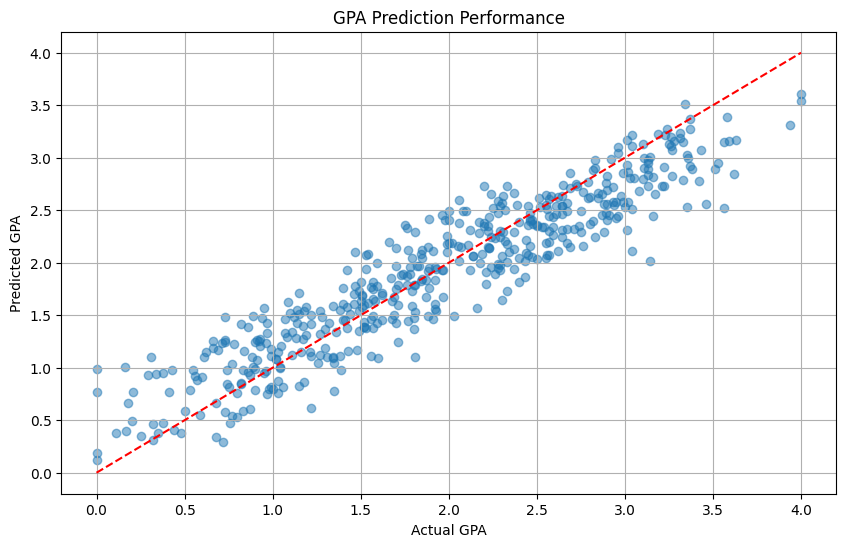

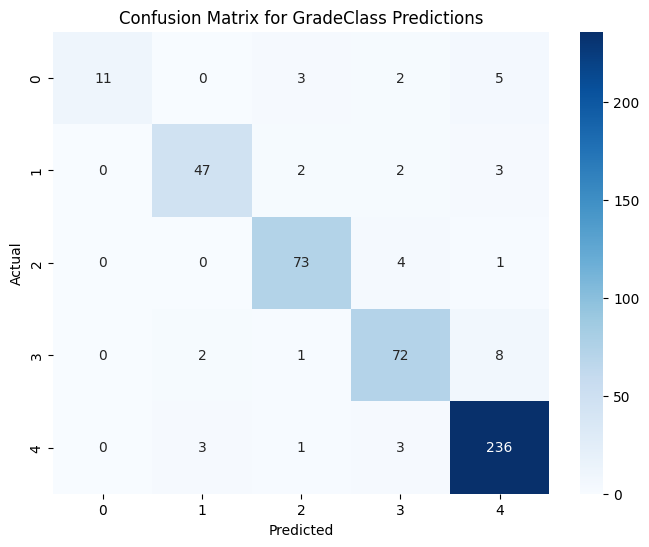

In [15]:
# Compare predicted vs actual GPA
plt.figure(figsize=(10, 6))
plt.scatter(test_df['GPA'], test_df['Predicted_GPA'], alpha=0.5)
plt.plot([0, 4], [0, 4], 'r--')  # Perfect prediction line
plt.xlabel('Actual GPA')
plt.ylabel('Predicted GPA')
plt.title('GPA Prediction Performance')
plt.grid(True)
plt.show()

# Confusion matrix for GradeClass predictions
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_df['GradeClass'], test_df['Predicted_GradeClass'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for GradeClass Predictions')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()